In [1]:
%load_ext autoreload
%autoreload 2

## Package Imports & Setup 

In [2]:
# setting project path
import os
import sys

gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# imports
import pandas as pd
import numpy as np


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier



from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

import xgboost as xgb

from boruta import BorutaPy

from src import classes as c
from src import functions as f

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import plotly
# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')

## Importing the Data

In [3]:
path = os.path.join(gparent, 'data/processed', 'modeling_remixed.csv')
df = pd.read_csv(path, keep_default_na=False)

## Preprocessing and Harness Objects

In [4]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

In [5]:
# creating f1 scorer
f1 = f.f1

In [6]:
modeling = c.Harness(f1)

## Creating the Baseline Dataframe

Dropping engineered features to establish the baseline score.

In [7]:
df.head(2)

,Target Remixed,Subject Age Group,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,...,Officer Squad,Frisk Flag,Precinct,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag
0,1,NA,None,7500,1984,M,Black,Asian,Male,NA,...,SOUTH PCT 1ST W - ROBERT,0,South,0,2015,10,16,4,11,1
1,0,NA,None,5670,1965,M,White,NA,NA,NA,...,NA,0,NA,0,2015,3,19,3,7,0


## Renaming the Target

In [8]:
df.rename(columns={'Target Remixed': 'Target'}, inplace=True)

In [9]:
df.head(2)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,...,Officer Squad,Frisk Flag,Precinct,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag
0,1,NA,None,7500,1984,M,Black,Asian,Male,NA,...,SOUTH PCT 1ST W - ROBERT,0,South,0,2015,10,16,4,11,1
1,0,NA,None,5670,1965,M,White,NA,NA,NA,...,NA,0,NA,0,2015,3,19,3,7,0


## Excluding Extraneous Features

In [10]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [11]:
# excluding Officer ID, 'Final Call Type', Frisk Flag & time features
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

## Baseline Data Frame

In [12]:
baseline_df = f.framer(df, [], excluded)

In [13]:
baseline_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct
0,1,NA,None,1984,M,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South
1,0,NA,None,1965,M,White,NA,NA,NA,NA,NA,NA


In [14]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46960 entries, 0 to 46959
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Target                    46960 non-null  int64 
 1   Subject Age Group         46960 non-null  object
 2   Weapon Type               46960 non-null  object
 3   Officer YOB               46960 non-null  int64 
 4   Officer Gender            46960 non-null  object
 5   Officer Race              46960 non-null  object
 6   Subject Perceived Race    46960 non-null  object
 7   Subject Perceived Gender  46960 non-null  object
 8   Initial Call Type         46960 non-null  object
 9   Call Type                 46960 non-null  object
 10  Officer Squad             46960 non-null  object
 11  Precinct                  46960 non-null  object
dtypes: int64(2), object(10)
memory usage: 4.3+ MB


## Creating X, y & Train Test Split

In [15]:
X, y = f.Xy(baseline_df)

In [16]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Baseline Logistic Regression

## Creating Pipeline

In [17]:
# adding a random state for a future solver gridsearch 
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=2)

In [18]:
baseline = make_pipeline(preprocessing_mm, LR)

## Fitting & Scoring Model

In [19]:
baseline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [20]:
#scoring the model
f1_score(y_train, baseline.predict(X_train))

0.884196120994762

## Cross Val Scores

In [21]:
# checking cross val scores
modeling.report(baseline, X_train, y_train, 'LR Baseline', 'Log Reg, min/max')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR Baseline has an average F1 of 0.8810525054191466


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


array([0.88269208, 0.88256816, 0.88164422, 0.88122696, 0.8771311 ])

## Sub-Splitting the Training Data

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


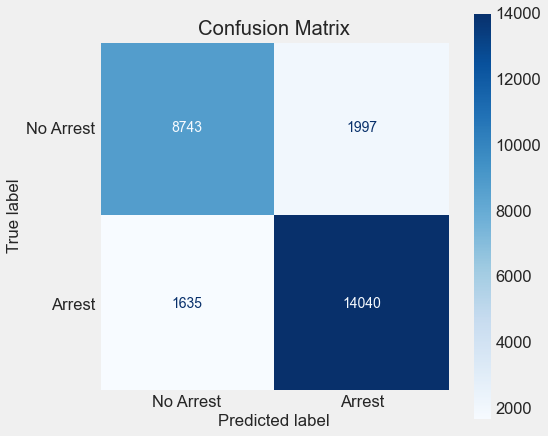

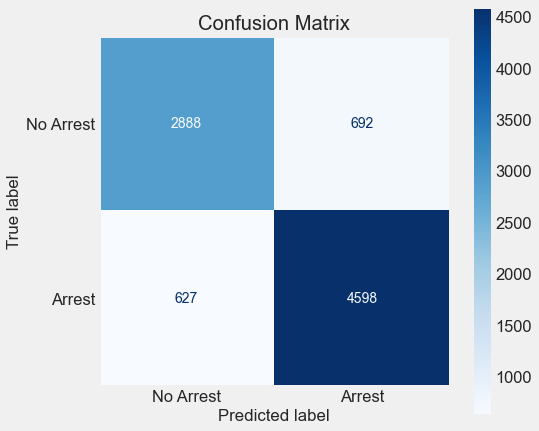

,Train F1,Test F1
0,0.885469,0.87456


In [22]:
f.subsplit_test(X_train, y_train, baseline)

## Baseline Score: F1 = 0.87456

## Baseline Logistic Regression w/smote

## Pipeline

In [23]:
baseline_smote = make_sm_pipeline(preprocessing_mm, sm, LR)

In [24]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [25]:
#scoring the model
f1_score(y_train, baseline_smote.predict(X_train))

0.8780940291949422

In [26]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR Baseline SMOTE', 'Log Reg min/max')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR Baseline SMOTE has an average F1 of 0.874411465797958


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


array([0.87512148, 0.87985393, 0.87170732, 0.87409231, 0.8712823 ])

In [27]:
modeling.history

,Name,Accuracy (F1),Notes
1,LR Baseline SMOTE,0.874411,Log Reg min/max
0,LR Baseline,0.881053,"Log Reg, min/max"


## Sub-Splitting the Training Data

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


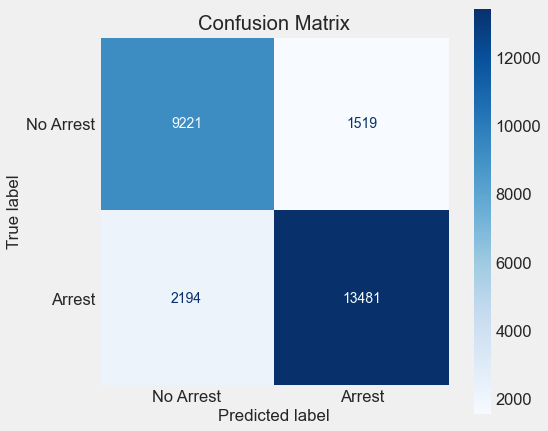

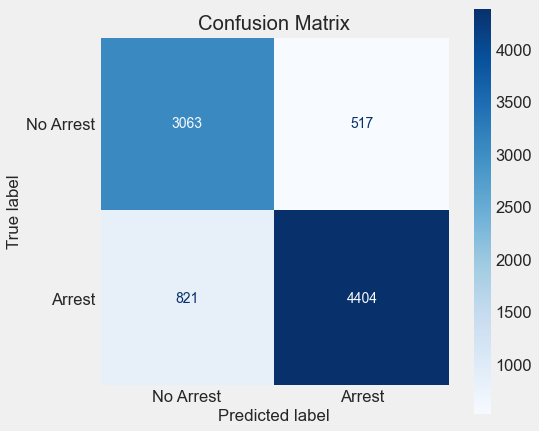

,Train F1,Test F1
0,0.878957,0.868125


In [28]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Baseline LR w/SMOTE Score: F1 = 0.868125

## Feature Engineering

## Dropping Subject and Officer Race Nulls

In [29]:
df = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA')]

In [30]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [31]:
# excluding Officer ID, 'Final Call Type', Frisk Flag & time features
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

## Creating New Data Frame w/Dropped Nulls

In [32]:
dropped_df = f.framer(df, [], excluded)

In [33]:
dropped_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct
0,1,NA,None,1984,M,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South
2,0,NA,None,1961,M,White,White,Male,NA,NA,NA,NA


## New Test Train Split

In [34]:
X, y = f.Xy(dropped_df)

In [35]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Baseline Logistic Regression w/o SMOTE on Dropped Nulls Data

## Pipeline

In [36]:
baseline_nosmote = make_pipeline(preprocessing_mm, LR)

In [37]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [38]:
#scoring the model
f1_score(y_train,baseline_nosmote.predict(X_train))

0.8906098741529526

In [39]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE', 'LR, Dropped Nulls')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE has an average F1 of 0.8872296084439542


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


array([0.88241826, 0.88584247, 0.88847445, 0.89044173, 0.88897113])

In [40]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR Baseline SMOTE,0.874411,Log Reg min/max
1,LR Baseline,0.881053,"Log Reg, min/max"
2,LR w/o SMOTE,0.887230,"LR, Dropped Nulls"


## Subsplit Test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


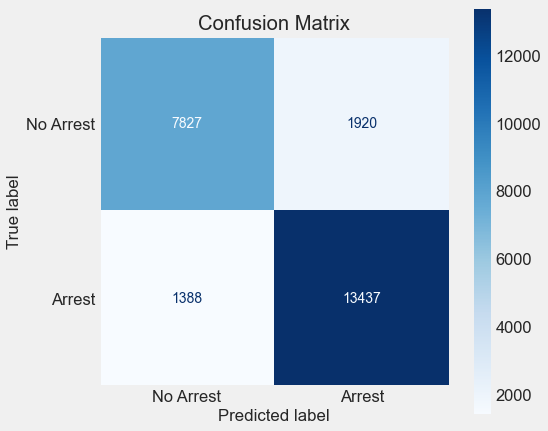

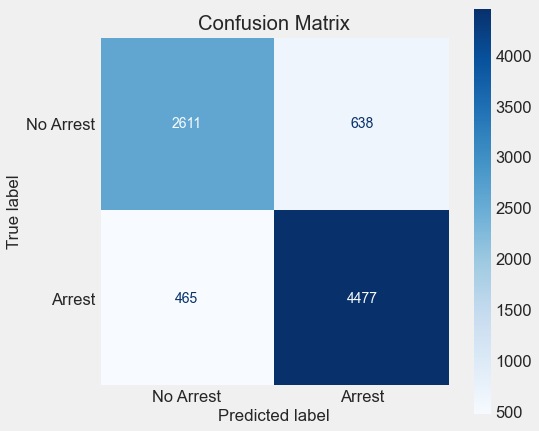

,Train F1,Test F1
0,0.890398,0.890325


In [41]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR No SMOTE on Dropped Nulls Score: 0.890325

## Baseline Logistic Regression w/SMOTE on Dropped Nulls Data

## Pipeline

In [42]:
baseline_smote = make_sm_pipeline(preprocessing_mm, sm, LR)

In [43]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [44]:
#scoring the model
f1_score(y_train,baseline_smote.predict(X_train))

0.8834931436230541

In [45]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE', 'LR, Dropped Nulls')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE has an average F1 of 0.8784407446482632


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


array([0.87348088, 0.8761165 , 0.88023797, 0.8808384 , 0.88152997])

In [46]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
1,LR Baseline,0.881053,"Log Reg, min/max"
2,LR w/o SMOTE,0.887230,"LR, Dropped Nulls"


## Sub-Splitting the Training Data

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


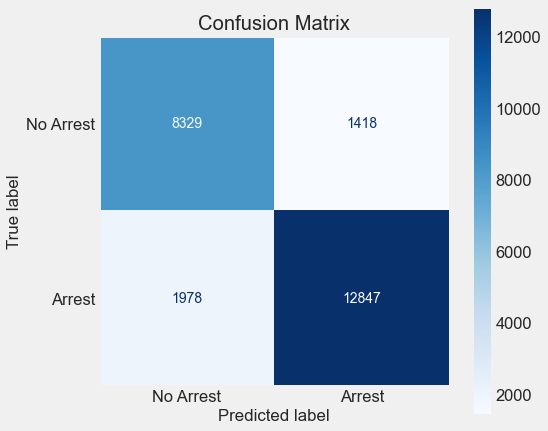

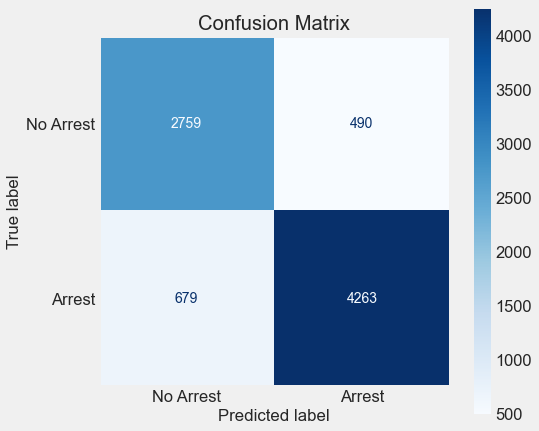

,Train F1,Test F1
0,0.883259,0.879422


In [47]:
f.subsplit_test(X_train, y_train, baseline_smote)

## LR w/SMOTE on Dropped Nulls Data Score: F1=0.879422

## Investigating the Data More Closely
Looking for some score improvement through feature engineering 

In [48]:
cols = baseline_df.columns
for col in cols:
    print(f'{df[col].value_counts()}\n')

1    26357
0    17328
Name: Target, dtype: int64

26 - 35         14651
36 - 45          9360
18 - 25          8828
46 - 55          5693
56 and Above     2228
1 - 17           1853
NA               1072
Name: Subject Age Group, dtype: int64

None                                    30763
NA                                      10307
Lethal Cutting Instrument                1417
Knife/Cutting/Stabbing Instrument         575
Handgun                                   269
Firearm Other                              94
Blunt Object/Striking Implement            78
Club, Blackjack, Brass Knuckles            46
Firearm                                    33
Mace/Pepper Spray                          24
Other Firearm                              18
Firearm (unk type)                         15
Taser/Stun Gun                             10
Club                                        8
None/Not Applicable                         7
Rifle                                       6
Fire/Incendiary Devic

In [49]:
baseline_df['Officer YOB'].describe()

count    46960.000000
mean      1982.972764
std          9.079240
min       1900.000000
25%       1978.000000
50%       1985.000000
75%       1990.000000
max       1998.000000
Name: Officer YOB, dtype: float64

## Creating & Testing Officer Age Feature
Creating `Officer Age` feature, dropping invalid ages and `Officer YOB` feature.

In [50]:
df['Officer Age'] = df['Reported Year'] - df['Officer YOB']
df['Officer Age'] = df['Officer Age'].apply(lambda x: np.nan if x > 100 else x)
df.dropna(subset = ['Officer Age'], inplace=True)

In [51]:
df.drop('Officer YOB', axis=1, inplace=True)

## New Data Frame

In [52]:
age_df = f.framer(df, [], excluded)

In [53]:
age_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Officer Age
0,1,NA,None,M,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,31.0
2,0,NA,None,M,White,White,Male,NA,NA,NA,NA,54.0


In [54]:
age_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43660 entries, 0 to 46959
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    43660 non-null  int64  
 1   Subject Age Group         43660 non-null  object 
 2   Weapon Type               43660 non-null  object 
 3   Officer Gender            43660 non-null  object 
 4   Officer Race              43660 non-null  object 
 5   Subject Perceived Race    43660 non-null  object 
 6   Subject Perceived Gender  43660 non-null  object 
 7   Initial Call Type         43660 non-null  object 
 8   Call Type                 43660 non-null  object 
 9   Officer Squad             43660 non-null  object 
 10  Precinct                  43660 non-null  object 
 11  Officer Age               43660 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 4.3+ MB


## New Test Train Split

In [55]:
X, y = f.Xy(age_df)

In [56]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Baseline LR on New Data

In [57]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [58]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

0.8891812720321731

In [59]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR w/o SMOTE', 'Dropped Nulls, officer age')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE has an average F1 of 0.8787473513717463


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


array([0.87301382, 0.88128149, 0.88231528, 0.87708494, 0.88004123])

In [60]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR Baseline SMOTE,0.874411,Log Reg min/max
1,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
2,LR Baseline,0.881053,"Log Reg, min/max"
3,LR w/o SMOTE,0.887230,"LR, Dropped Nulls"


## Subsplit Test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


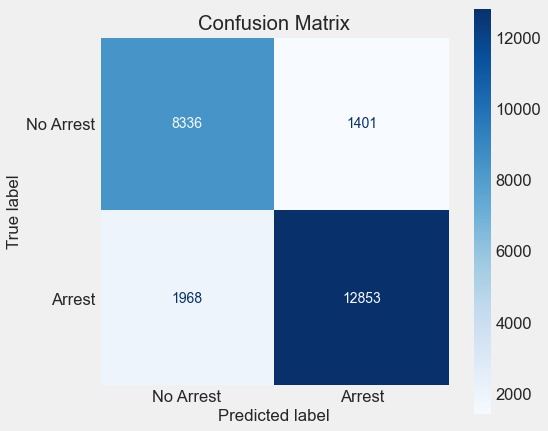

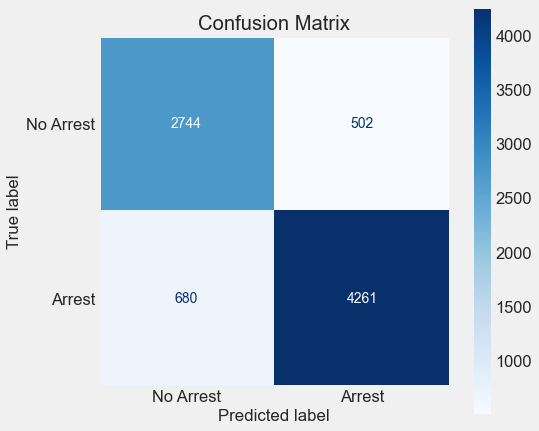

,Train F1,Test F1
0,0.884127,0.878195


In [61]:
f.subsplit_test(X_train, y_train, baseline_smote)

## LR w/Officer Age Score: F1=0.878195

## Creating Racial Affinity Feature
0 if subject and officer are different races; 1 if subject and officer are different races.

In [62]:
df['Racial Affinity'] = [1 if df['Subject Perceived Race'][row]\
                         == df['Officer Race'][row] else 0 for row in df.index]

In [63]:
df.head(3)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,...,Precinct,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag,Officer Age,Racial Affinity
0,1,NA,None,7500,M,Black,Asian,Male,NA,NA,...,South,0,2015,10,16,4,11,1,31.0,0
2,0,NA,None,4844,M,White,White,Male,NA,NA,...,NA,0,2015,3,21,5,19,0,54.0,1
4,0,NA,None,6973,M,White,Black,Male,NA,NA,...,NA,0,2015,4,3,4,0,0,38.0,0


## New Data Frame

In [64]:
# excluding Officer ID, 'Final Call Type', and Frisk Flag
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age']

In [65]:
RA_df = f.framer(df, [], excluded)

In [66]:
RA_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Racial Affinity
0,1,NA,None,M,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,0
2,0,NA,None,M,White,White,Male,NA,NA,NA,NA,1


In [67]:
X, y = f.Xy(RA_df)

In [68]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Racial Affinity Feature

In [69]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [70]:
#scoring the model
f1_score(y_train,baseline_nosmote.predict(X_train))

0.889241920270069

In [71]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE ', 'Dropped Nulls, racial affinity')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE  has an average F1 of 0.8856132891331248


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


array([0.88053591, 0.88836341, 0.88949253, 0.88436725, 0.88530735])

In [72]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR Baseline SMOTE,0.874411,Log Reg min/max
1,LR SMOTE,0.878441,"LR, Dropped Nulls"
2,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
3,LR Baseline,0.881053,"Log Reg, min/max"
5,LR w/o SMOTE,0.885613,"Dropped Nulls, racial affinity"
4,LR w/o SMOTE,0.887230,"LR, Dropped Nulls"


## Subsplit Test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


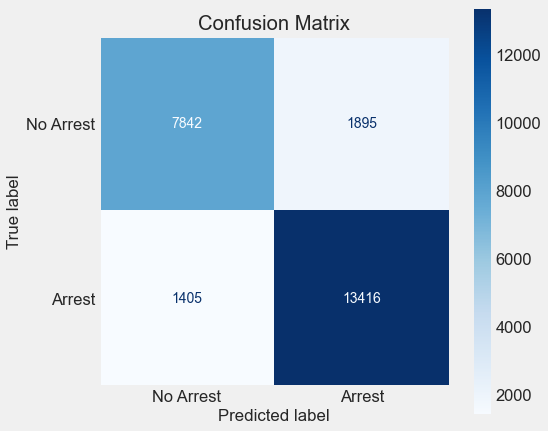

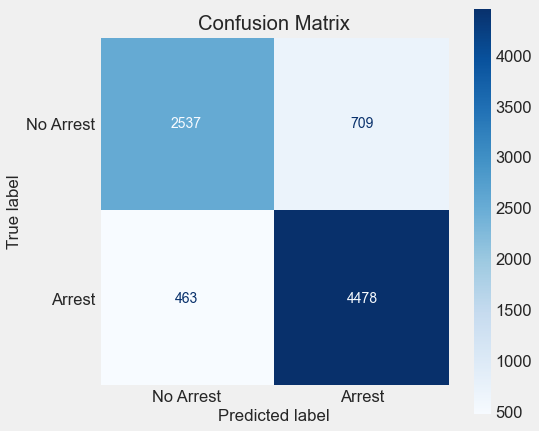

,Train F1,Test F1
0,0.890482,0.884281


In [73]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Racial Affinity Score: F1=0.884281

## Gender Affinity Feature
0 if subject and officer are different genders; 1 if the same.

In [74]:
df['Officer Gender'].value_counts()

M    38657
F     5003
Name: Officer Gender, dtype: int64

In [75]:
df['Officer Gender'] = df['Officer Gender'].apply(lambda x: 'Male' if x=='M' else 'Female')

In [76]:
df['Gender Affinity'] = [1 if df['Subject Perceived Gender'][row]\
                         == df['Officer Gender'][row] else 0 for row in df.index]

In [77]:
df.head(2)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,...,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag,Officer Age,Racial Affinity,Gender Affinity
0,1,NA,None,7500,Male,Black,Asian,Male,NA,NA,...,0,2015,10,16,4,11,1,31.0,0,1
2,0,NA,None,4844,Male,White,White,Male,NA,NA,...,0,2015,3,21,5,19,0,54.0,1,1


## New Data Frame

In [78]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity']

In [79]:
GA_df = f.framer(df, [], excluded)

In [80]:
GA_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Gender Affinity
0,1,NA,None,Male,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,1
2,0,NA,None,Male,White,White,Male,NA,NA,NA,NA,1


In [81]:
X, y = f.Xy(GA_df)

In [82]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Gender Affinity

In [83]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [84]:
#scoring the model
f1_score(y_train,baseline_nosmote.predict(X_train))

0.8890709568498933

In [85]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE ', 'Dropped Nulls, gender affinity')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE  has an average F1 of 0.885576773725723


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


array([0.88065436, 0.88803185, 0.88930072, 0.88428625, 0.8856107 ])

In [86]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR Baseline SMOTE,0.874411,Log Reg min/max
1,LR SMOTE,0.878441,"LR, Dropped Nulls"
2,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
3,LR Baseline,0.881053,"Log Reg, min/max"
6,LR w/o SMOTE,0.885577,"Dropped Nulls, gender affinity"
4,LR w/o SMOTE,0.885613,"Dropped Nulls, racial affinity"
5,LR w/o SMOTE,0.887230,"LR, Dropped Nulls"


## Subsplit Test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


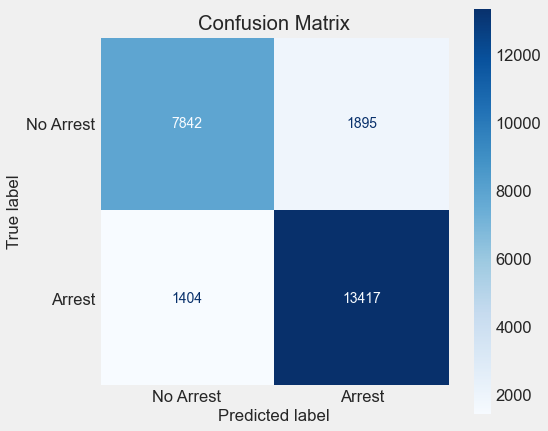

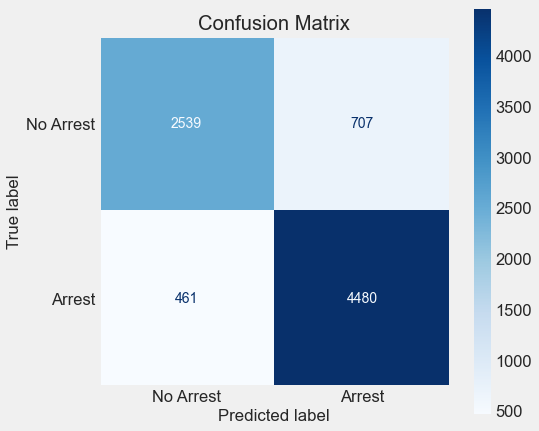

,Train F1,Test F1
0,0.890519,0.884676


In [87]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Gender Affinity Score: F1=0.884676

## Binning Weapon Type
Binning into NONE, GUN, KNIFE, OTHER

In [88]:
# checking weapon types
df['Weapon Type'].unique()

array(['None', 'Firearm Other', 'Handgun', 'Lethal Cutting Instrument',
       'NA', 'Club, Blackjack, Brass Knuckles',
       'Knife/Cutting/Stabbing Instrument', 'Other Firearm',
       'Fire/Incendiary Device', 'Blunt Object/Striking Implement',
       'Firearm (unk type)', 'Mace/Pepper Spray', 'None/Not Applicable',
       'Club', 'Rifle', 'Firearm', 'Taser/Stun Gun', 'Shotgun',
       'Brass Knuckles', 'Automatic Handgun', 'Blackjack',
       'Personal Weapons (hands, feet, etc.)'], dtype=object)

In [89]:
NONE= ['None', 'NA','None/Not Applicable']

GUN = ['Firearm Other', 'Handgun', 'Other Firearm',
        'Rifle', 'Firearm (unk type)', 'Firearm',
        'Shotgun', 'Automatic Handgun']

KNIFE = ['Lethal Cutting Instrument', 'Knife/Cutting/Stabbing Instrument']

OTHER = ['Club, Blackjack, Brass Knuckles',
         'Fire/Incendiary Device', 'Blunt Object/Striking Implement',
         'Mace/Pepper Spray', 'Club', 'Taser/Stun Gun',
         'Brass Knuckles','Blackjack',
         'Personal Weapons (hands, feet, etc.)']

In [90]:
df['Weapon Bins'] = df['Weapon Type'].copy()

In [91]:
df['Weapon Bins']

0                                     None
2                                     None
4                                     None
5                                     None
6                                     None
                       ...                
46955    Knife/Cutting/Stabbing Instrument
46956                                   NA
46957                        Other Firearm
46958                                   NA
46959                                   NA
Name: Weapon Bins, Length: 43660, dtype: object

In [92]:
for type in NONE:
    df['Weapon Bins'].replace(type, 'NONE', inplace=True)
for type in GUN:
    df['Weapon Bins'].replace(type, 'GUN', inplace=True)
for type in KNIFE:
    df['Weapon Bins'].replace(type, 'KNIFE', inplace=True)
for type in OTHER:
    df['Weapon Bins'].replace(type, 'OTHER', inplace=True)

In [93]:
df['Weapon Bins'].value_counts(normalize=True)

NONE     0.940289
KNIFE    0.045602
GUN      0.010078
OTHER    0.004031
Name: Weapon Bins, dtype: float64

## 94% of Subjects Are Unarmed and Only 1% Have a Gun.

In [94]:
df.head(2)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,...,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag,Officer Age,Racial Affinity,Gender Affinity,Weapon Bins
0,1,NA,None,7500,Male,Black,Asian,Male,NA,NA,...,2015,10,16,4,11,1,31.0,0,1,NONE
2,0,NA,None,4844,Male,White,White,Male,NA,NA,...,2015,3,21,5,19,0,54.0,1,1,NONE


## New Data Frame w/Weapons Bins

In [95]:
excluded = ['Weapon Type', 'Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity']

In [96]:
WB_df = f.framer(df, [], excluded)

In [97]:
WB_df.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Weapon Bins
0,1,NA,Male,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,NONE
2,0,NA,Male,White,White,Male,NA,NA,NA,NA,NONE


In [98]:
X, y = f.Xy(WB_df)

In [99]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Weapon Bins

In [100]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [101]:
#scoring the model
f1_score(y_train,baseline_nosmote.predict(X_train))

0.8753161234909577

In [102]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE ', 'Dropped Nulls, weapon bins')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE  has an average F1 of 0.8732731002854633


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


array([0.87071429, 0.87295718, 0.87626533, 0.87315212, 0.87327659])

In [103]:
modeling.history

,Name,Accuracy (F1),Notes
7,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
0,LR Baseline SMOTE,0.874411,Log Reg min/max
1,LR SMOTE,0.878441,"LR, Dropped Nulls"
2,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
3,LR Baseline,0.881053,"Log Reg, min/max"
4,LR w/o SMOTE,0.885577,"Dropped Nulls, gender affinity"
5,LR w/o SMOTE,0.885613,"Dropped Nulls, racial affinity"
6,LR w/o SMOTE,0.887230,"LR, Dropped Nulls"


## Subsplit Test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


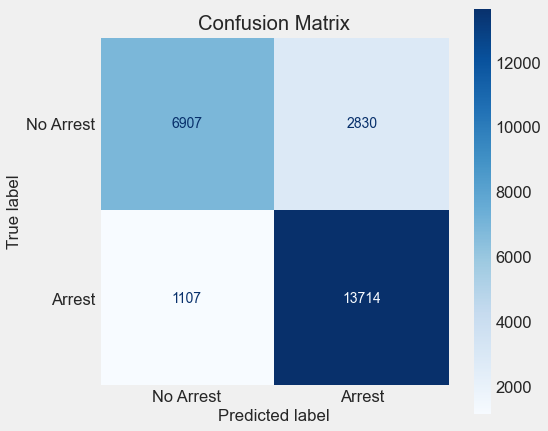

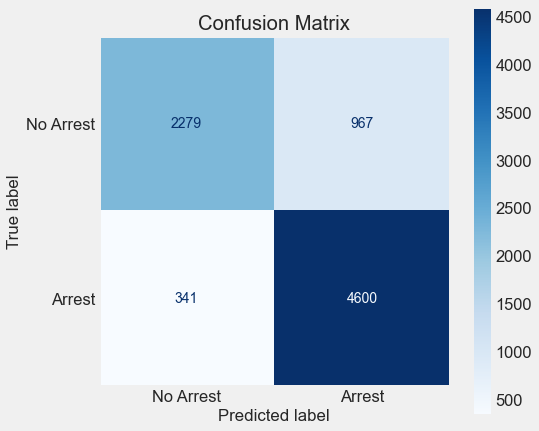

,Train F1,Test F1
0,0.874478,0.875523


In [104]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Weapon Bins Score: F1=0.875523

## Testing Weapon Flag
The weapon flag binary (0 = no weapon) has been excluded from tests up to this point.

## New Data Frame

In [105]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Type', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins']

In [106]:
WF_df = f.framer(df, [], excluded)

In [107]:
WF_df.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Weapon Flag
0,1,NA,Male,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,0
2,0,NA,Male,White,White,Male,NA,NA,NA,NA,0


In [108]:
X, y = f.Xy(WF_df)

In [109]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Weapon Flag

In [110]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [111]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

0.8753370076110037

In [112]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE ', 'Dropped Nulls, weapon flag')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE  has an average F1 of 0.8732586135599082


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


array([0.87061064, 0.87295718, 0.87602715, 0.87328645, 0.87341165])

In [113]:
modeling.history

,Name,Accuracy (F1),Notes
8,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
0,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
1,LR Baseline SMOTE,0.874411,Log Reg min/max
2,LR SMOTE,0.878441,"LR, Dropped Nulls"
3,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
4,LR Baseline,0.881053,"Log Reg, min/max"
5,LR w/o SMOTE,0.885577,"Dropped Nulls, gender affinity"
6,LR w/o SMOTE,0.885613,"Dropped Nulls, racial affinity"
7,LR w/o SMOTE,0.887230,"LR, Dropped Nulls"


## Subsplit Test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


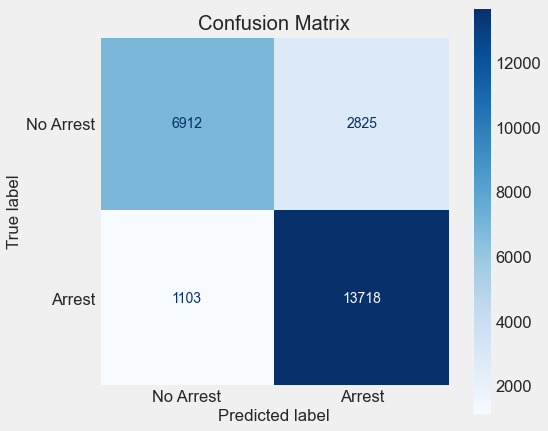

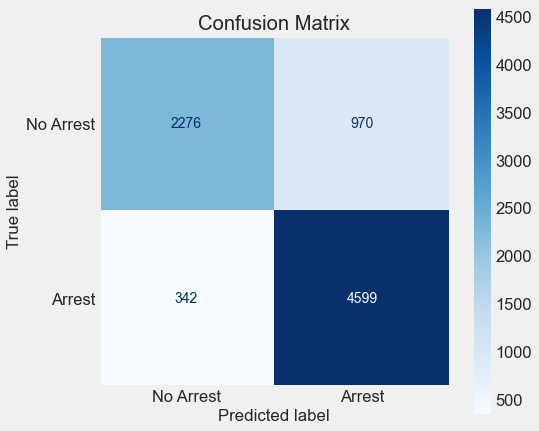

,Train F1,Test F1
0,0.874761,0.875167


In [114]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Weapon Flag Score: F1=0.875167

## Binarizing Initial Call Type
0 = no call information provided.

In [115]:
df['Initial Call Bin'] = df['Initial Call Type'].copy()

In [116]:
df['Initial Call Bin'] = df['Initial Call Bin'].replace('NA', 0)
df['Initial Call Bin'] = df['Initial Call Bin'].map(lambda x: 1 if x!=0 else 0)

In [117]:
df['Initial Call Bin'].value_counts()

1    31268
0    12392
Name: Initial Call Bin, dtype: int64

## New Data Frame

In [118]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 'Initial Call Type']

In [119]:
ICB_df = f.framer(df, [], excluded)

In [120]:
ICB_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Call Type,Officer Squad,Precinct,Initial Call Bin
0,1,NA,None,Male,Black,Asian,Male,NA,SOUTH PCT 1ST W - ROBERT,South,0
2,0,NA,None,Male,White,White,Male,NA,NA,NA,0


In [121]:
X, y = f.Xy(ICB_df)

In [122]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Initial Call Type Binary

In [123]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [124]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

0.8825751030584286

In [125]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE ', 'Dropped Nulls, Initial Call Binary')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE  has an average F1 of 0.8805836214650842


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


array([0.87609204, 0.88340531, 0.88412757, 0.87868691, 0.88060629])

In [126]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
9,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
5,LR Baseline,0.881053,"Log Reg, min/max"
6,LR w/o SMOTE,0.885577,"Dropped Nulls, gender affinity"
7,LR w/o SMOTE,0.885613,"Dropped Nulls, racial affinity"
8,LR w/o SMOTE,0.887230,"LR, Dropped Nulls"


## Subsplit Test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


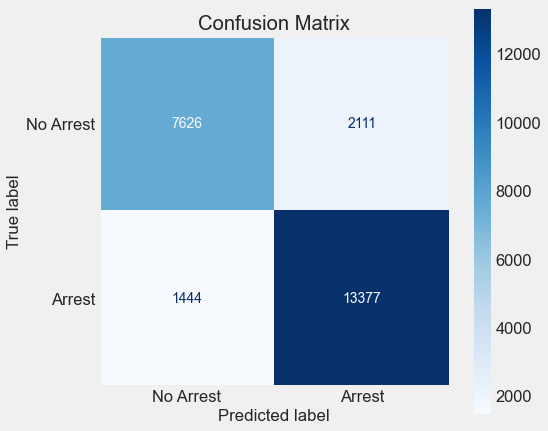

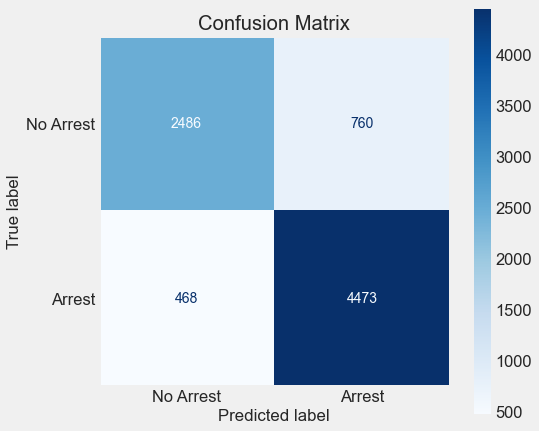

,Train F1,Test F1
0,0.882708,0.8793


In [127]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Initial Call Types Binary Score: F1=0.8793

## Binning Call Types
Binning into 911, OTHER, ONVIEW.

In [128]:
types = df['Call Type'].unique()

In [129]:
replace_list = [x for x in types if (x!='911') and (x!='ONVIEW')]

In [130]:
df['Call Type Bins'] = df['Call Type'].copy()

In [131]:
df['Call Type Bins'] = df['Call Type Bins'].replace(replace_list, 'OTHER')

In [132]:
df['Call Type Bins'].value_counts(normalize=True)

911       0.452268
OTHER     0.361361
ONVIEW    0.186372
Name: Call Type Bins, dtype: float64

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43660 entries, 0 to 46959
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    43660 non-null  int64  
 1   Subject Age Group         43660 non-null  object 
 2   Weapon Type               43660 non-null  object 
 3   Officer ID                43660 non-null  object 
 4   Officer Gender            43660 non-null  object 
 5   Officer Race              43660 non-null  object 
 6   Subject Perceived Race    43660 non-null  object 
 7   Subject Perceived Gender  43660 non-null  object 
 8   Initial Call Type         43660 non-null  object 
 9   Final Call Type           43660 non-null  object 
 10  Call Type                 43660 non-null  object 
 11  Officer Squad             43660 non-null  object 
 12  Frisk Flag                43660 non-null  int64  
 13  Precinct                  43660 non-null  object 
 14  Weapon

## New Data Frame

In [134]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 
            'Initial Call Bin','Call Type']

In [135]:
BCT_df = f.framer(df, [], excluded)

In [136]:
BCT_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Officer Squad,Precinct,Call Type Bins
0,1,NA,None,Male,Black,Asian,Male,NA,SOUTH PCT 1ST W - ROBERT,South,OTHER
2,0,NA,None,Male,White,White,Male,NA,NA,NA,OTHER


In [137]:
X, y = f.Xy(BCT_df)

In [138]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Call Type Bins

In [139]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [140]:
#scoring the model
f1_score(y_train,baseline_nosmote.predict(X_train))

0.8891371264025419

In [141]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE ', 'Dropped Nulls, call type bins')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE  has an average F1 of 0.885498244229375


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


array([0.88042669, 0.8881145 , 0.8893554 , 0.88420531, 0.88538933])

In [142]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
10,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"
7,LR w/o SMOTE,0.885577,"Dropped Nulls, gender affinity"
8,LR w/o SMOTE,0.885613,"Dropped Nulls, racial affinity"


## Subsplits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


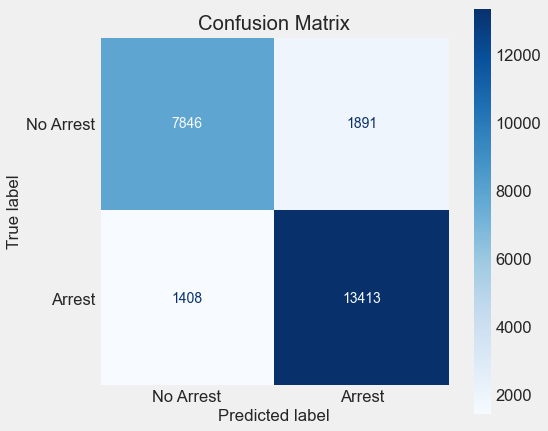

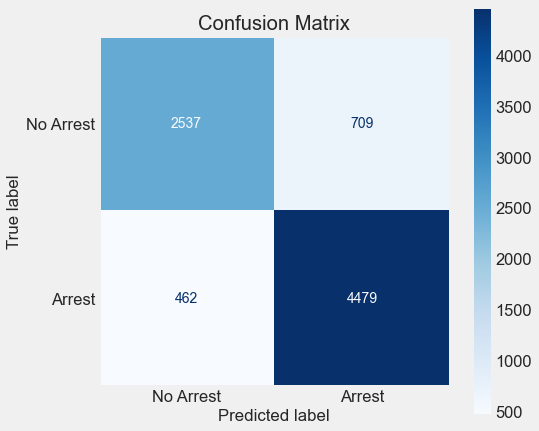

,Train F1,Test F1
0,0.89049,0.884391


In [143]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Call Type Bins Score: F1=0.884391

## Binning the Squad Data
The squads look like they can be binned into precinct goups, a training group and an group of smaller precincts. 

In [144]:
df['Officer Squad Bins'] = df['Officer Squad'].copy()

In [145]:
df['Officer Squad Bins'] = df['Officer Squad Bins'].map(lambda x: x[0])

In [146]:
df['Officer Squad Bins'].value_counts(normalize=True)

W    0.277119
N    0.253275
S    0.210009
E    0.136395
T    0.110330
C    0.009345
G    0.001306
H    0.000710
M    0.000412
B    0.000206
J    0.000206
A    0.000183
D    0.000183
R    0.000160
P    0.000115
Z    0.000023
V    0.000023
Name: Officer Squad Bins, dtype: float64

In [147]:
proportions = df['Officer Squad Bins'].value_counts(normalize=True)
cutoff_idx = proportions.loc[proportions < .02].index
for i in cutoff_idx:
    df['Officer Squad Bins'].replace(i, 'OTHER', inplace=True)

In [148]:
df['Officer Squad Bins'].value_counts()

W        12099
N        11058
S         9169
E         5955
T         4817
OTHER      562
Name: Officer Squad Bins, dtype: int64

## New Data Frame

In [149]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 
            'Initial Call Bin','Call Type Bins', 'Officer Squad']

In [150]:
BSQ_df = f.framer(df, [], excluded)

In [151]:
BSQ_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Precinct,Officer Squad Bins
0,1,NA,None,Male,Black,Asian,Male,NA,NA,South,S
2,0,NA,None,Male,White,White,Male,NA,NA,NA,N


In [152]:
X, y = f.Xy(BSQ_df)

In [153]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Precinct Bins

In [154]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [155]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

0.8864583333333332

In [156]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE', 'Dropped Nulls, Squad Bins')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE has an average F1 of 0.8847169493409648


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


array([0.88042669, 0.88551518, 0.88735519, 0.8851728 , 0.88511489])

In [157]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
11,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
7,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"
8,LR w/o SMOTE,0.885577,"Dropped Nulls, gender affinity"


## Subsplits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


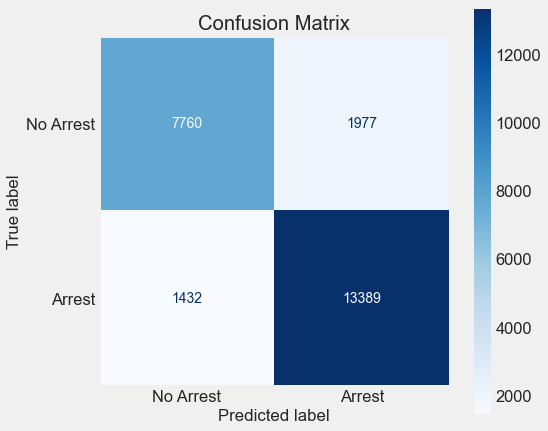

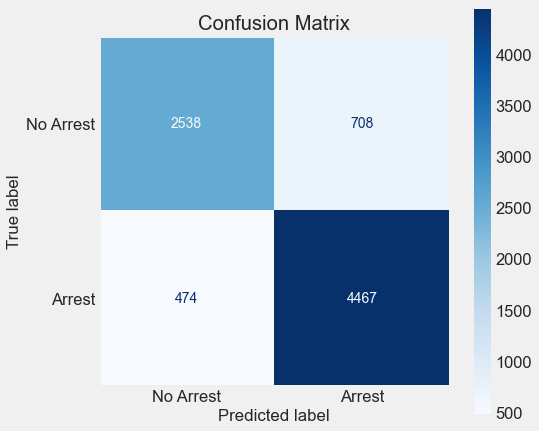

,Train F1,Test F1
0,0.887071,0.883155


In [158]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Precinct Bins Score: F1=0.883155

## Binarizing Officer Race
Binarizing into White and Non-White.

In [159]:
df['Officer Race Bins'] = df['Officer Race'].copy()

In [160]:
df['Officer Race Bins'].replace('White', 1, inplace=True)

In [161]:
df['Officer Race Bins'] = df['Officer Race Bins'].apply(lambda x: 0 if x!=1 else 1)

In [162]:
df['Officer Race Bins'].value_counts()

1    34103
0     9557
Name: Officer Race Bins, dtype: int64

In [163]:
df['Officer Race Bins'].value_counts(normalize=True)

1    0.781104
0    0.218896
Name: Officer Race Bins, dtype: float64

## New Data Frame

In [164]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 
            'Initial Call Bin','Call Type Bins', 'Officer Squad Bins',
            'Officer Race']

In [165]:
ORB_df = f.framer(df, [], excluded)

In [166]:
ORB_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Officer Race Bins
0,1,NA,None,Male,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,0
2,0,NA,None,Male,White,Male,NA,NA,NA,NA,1


In [167]:
X, y = f.Xy(ORB_df)

In [168]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Officer Race Binary

In [169]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [170]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

0.8893909675497182

In [171]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE', 'Dropped Nulls, Officer Race Bins')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE has an average F1 of 0.8855252933136862


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


array([0.88095238, 0.88797712, 0.88946523, 0.88444831, 0.88478342])

In [172]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
8,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"
12,LR w/o SMOTE,0.885525,"Dropped Nulls, Officer Race Bins"


## Subsplits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


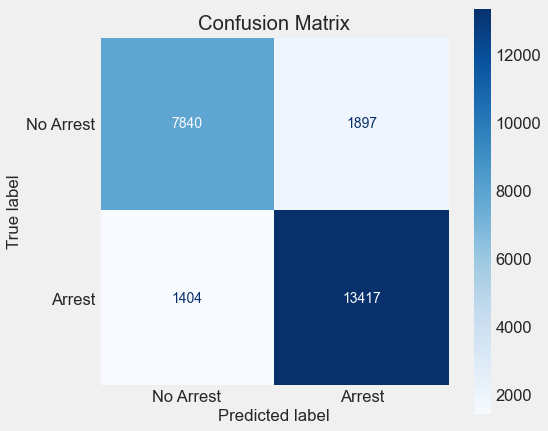

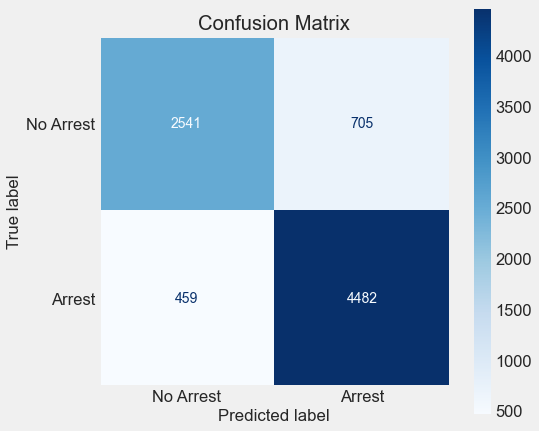

,Train F1,Test F1
0,0.89046,0.885071


In [173]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Officer Race Binary Score: F1=0.885071

## Testing on Top Features w/o Time
Test LR with features that perfomed better than the baseline features.

## New Data Frame

In [174]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour']

In [175]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Weapon Bins', 'Officer Race',
            'Initial Call Bin']

In [176]:
df_6 = f.framer(df, [], excluded)

In [177]:
df_6.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Racial Affinity,Gender Affinity,Call Type Bins,Officer Squad Bins,Officer Race Bins
0,1,NA,None,Male,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,0,1,OTHER,S,0
2,0,NA,None,Male,White,Male,NA,NA,NA,NA,1,1,OTHER,N,1


In [178]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43660 entries, 0 to 46959
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Target                    43660 non-null  int64 
 1   Subject Age Group         43660 non-null  object
 2   Weapon Type               43660 non-null  object
 3   Officer Gender            43660 non-null  object
 4   Subject Perceived Race    43660 non-null  object
 5   Subject Perceived Gender  43660 non-null  object
 6   Initial Call Type         43660 non-null  object
 7   Call Type                 43660 non-null  object
 8   Officer Squad             43660 non-null  object
 9   Precinct                  43660 non-null  object
 10  Racial Affinity           43660 non-null  int64 
 11  Gender Affinity           43660 non-null  int64 
 12  Call Type Bins            43660 non-null  object
 13  Officer Squad Bins        43660 non-null  object
 14  Officer Race Bins     

In [179]:
X, y = f.Xy(df_6)

In [180]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing

In [181]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [182]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

0.8893247269116186

In [183]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train,\
                'LR w/o SMOTE', 'Top Features w/o Time, Dropped Nulls')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE has an average F1 of 0.8854208674880357


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


array([0.88087269, 0.88808754, 0.88921823, 0.88422881, 0.88469706])

In [184]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
13,LR w/o SMOTE,0.885421,"Top Features w/o Time, Dropped Nulls"
8,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"


## Testing on Sub-Splits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


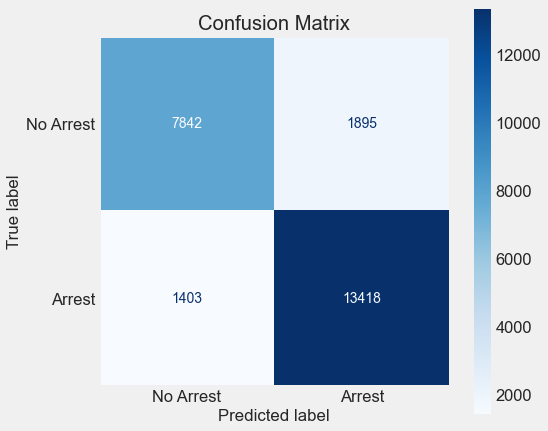

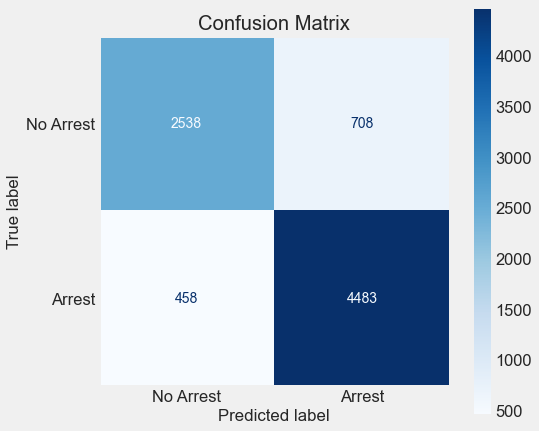

,Train F1,Test F1
0,0.890556,0.884919


In [185]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR Top Features w/o Time Score: F1=0.884919

## Testing on All Features w/o Time

## New Data Frame

In [186]:
# Dropping Subject Age Nulls
df = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA') &\
           (df['Subject Age Group']!='NA')]

In [187]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour']

In [188]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag',
           'Reported Year', 'Reported Month', 'Day of Month', 'Day of Week', 'Reported Hour']

In [189]:
df_7 = f.framer(df, [], excluded)

In [190]:
df_7.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Beat Flag,Officer Age,Racial Affinity,Gender Affinity,Weapon Bins,Initial Call Bin,Call Type Bins,Officer Squad Bins,Officer Race Bins
214,0,1 - 17,None,Male,White,White,Male,NA,NA,NA,NA,0,27.0,1,1,NONE,0,OTHER,N,1
328,0,36 - 45,None,Male,White,Asian,Male,NA,NA,NA,NA,0,37.0,0,1,NONE,0,OTHER,N,1


In [191]:
df_7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42589 entries, 214 to 46959
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    42589 non-null  int64  
 1   Subject Age Group         42589 non-null  object 
 2   Weapon Type               42589 non-null  object 
 3   Officer Gender            42589 non-null  object 
 4   Officer Race              42589 non-null  object 
 5   Subject Perceived Race    42589 non-null  object 
 6   Subject Perceived Gender  42589 non-null  object 
 7   Initial Call Type         42589 non-null  object 
 8   Call Type                 42589 non-null  object 
 9   Officer Squad             42589 non-null  object 
 10  Precinct                  42589 non-null  object 
 11  Beat Flag                 42589 non-null  int64  
 12  Officer Age               42589 non-null  float64
 13  Racial Affinity           42589 non-null  int64  
 14  Gend

In [192]:
X, y = f.Xy(df_7)

In [193]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing LR All Features w/o Time

In [194]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [195]:
#scoring the model
f1_score(y_train,baseline_nosmote.predict(X_train))

0.8908076447272084

In [196]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train,'LR w/o SMOTE', 'All Features w/o Time, Dropped Nulls')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE has an average F1 of 0.887738641013511


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


array([0.89257862, 0.88841039, 0.88726171, 0.88380282, 0.88663968])

In [197]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
8,LR w/o SMOTE,0.885421,"Top Features w/o Time, Dropped Nulls"
9,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"


## Testing on Sub-Splits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


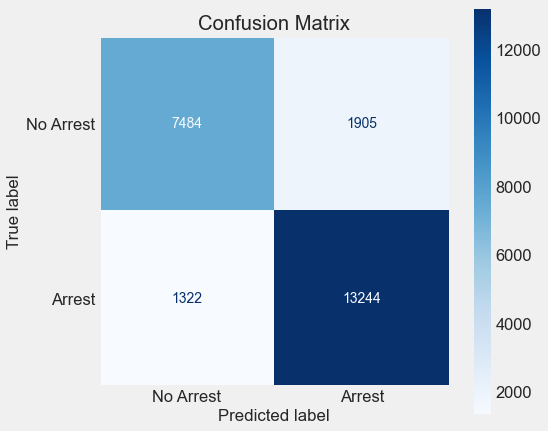

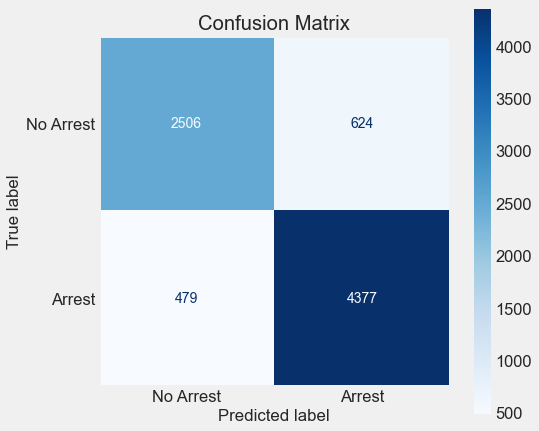

,Train F1,Test F1
0,0.891402,0.8881


In [198]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR All Features w/o Time Score: F1=0.8881

## Testing Top Features w/o Time Dropped Subject Age

## New Data Frame

In [199]:
# Dropping Subject Age Nulls
df = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA') &\
           (df['Subject Age Group']!='NA')]

In [200]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour']

In [201]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Weapon Bins', 'Officer Race',
            'Initial Call Bin']

In [202]:
df_8 = f.framer(df, [], excluded)

In [203]:
df_8.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Racial Affinity,Gender Affinity,Call Type Bins,Officer Squad Bins,Officer Race Bins
214,0,1 - 17,None,Male,White,Male,NA,NA,NA,NA,1,1,OTHER,N,1
328,0,36 - 45,None,Male,Asian,Male,NA,NA,NA,NA,0,1,OTHER,N,1


In [204]:
df_8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42589 entries, 214 to 46959
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Target                    42589 non-null  int64 
 1   Subject Age Group         42589 non-null  object
 2   Weapon Type               42589 non-null  object
 3   Officer Gender            42589 non-null  object
 4   Subject Perceived Race    42589 non-null  object
 5   Subject Perceived Gender  42589 non-null  object
 6   Initial Call Type         42589 non-null  object
 7   Call Type                 42589 non-null  object
 8   Officer Squad             42589 non-null  object
 9   Precinct                  42589 non-null  object
 10  Racial Affinity           42589 non-null  int64 
 11  Gender Affinity           42589 non-null  int64 
 12  Call Type Bins            42589 non-null  object
 13  Officer Squad Bins        42589 non-null  object
 14  Officer Race Bins   

In [205]:
X, y = f.Xy(df_8)

In [206]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing

In [207]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [208]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

0.890375343918015

In [209]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train,\
                'LR w/o SMOTE', 'Top Features w/o Time, Dpd Nulls Race, Age')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE has an average F1 of 0.8874350703172629


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


array([0.89280322, 0.88793213, 0.8875142 , 0.88355131, 0.88537449])

In [210]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
8,LR w/o SMOTE,0.885421,"Top Features w/o Time, Dropped Nulls"
9,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"


## Testing on Sub-Splits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


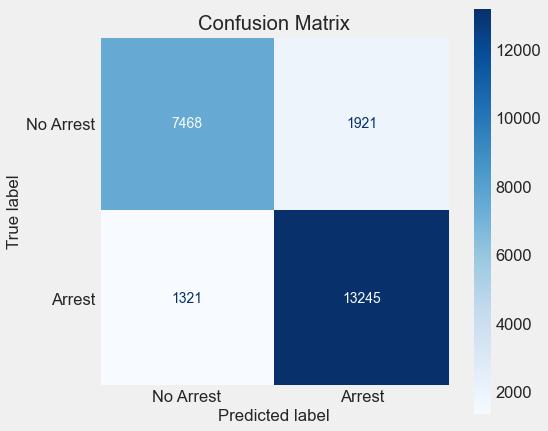

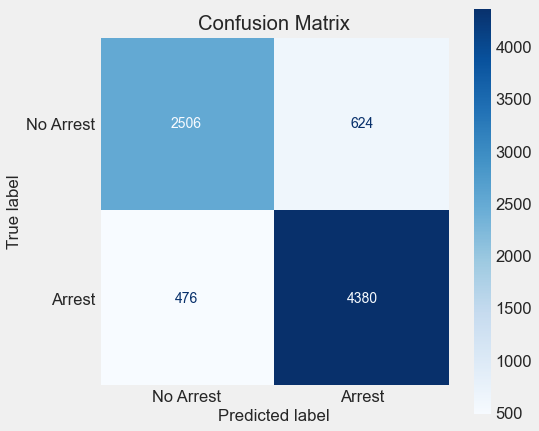

,Train F1,Test F1
0,0.890959,0.888438


In [211]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR Top Features Dropped Subject Age Score: F1=0.888438

## Testing on All Features w/o Time Dropped Subject Age

## Data Frame

In [212]:
# Dropping Subject Age Nulls
df = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA') &\
           (df['Subject Age Group']!='NA')]

In [213]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour']

In [214]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag',
           'Reported Year', 'Reported Month', 'Day of Month', 'Day of Week', 'Reported Hour']

In [215]:
df_9 = f.framer(df, [], excluded)

In [216]:
df_9.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Beat Flag,Officer Age,Racial Affinity,Gender Affinity,Weapon Bins,Initial Call Bin,Call Type Bins,Officer Squad Bins,Officer Race Bins
214,0,1 - 17,None,Male,White,White,Male,NA,NA,NA,NA,0,27.0,1,1,NONE,0,OTHER,N,1
328,0,36 - 45,None,Male,White,Asian,Male,NA,NA,NA,NA,0,37.0,0,1,NONE,0,OTHER,N,1


In [217]:
df_9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42589 entries, 214 to 46959
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    42589 non-null  int64  
 1   Subject Age Group         42589 non-null  object 
 2   Weapon Type               42589 non-null  object 
 3   Officer Gender            42589 non-null  object 
 4   Officer Race              42589 non-null  object 
 5   Subject Perceived Race    42589 non-null  object 
 6   Subject Perceived Gender  42589 non-null  object 
 7   Initial Call Type         42589 non-null  object 
 8   Call Type                 42589 non-null  object 
 9   Officer Squad             42589 non-null  object 
 10  Precinct                  42589 non-null  object 
 11  Beat Flag                 42589 non-null  int64  
 12  Officer Age               42589 non-null  float64
 13  Racial Affinity           42589 non-null  int64  
 14  Gend

In [218]:
X, y = f.Xy(df_9)

In [219]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing

In [220]:
baseline_nosmote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Scoring

In [221]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

0.8908076447272084

In [222]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train,\
                'LR w/o SMOTE', 'All Features w/o Time, Dpd Nulls Race, Age')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR w/o SMOTE has an average F1 of 0.887738641013511


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


array([0.89257862, 0.88841039, 0.88726171, 0.88380282, 0.88663968])

In [223]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
8,LR w/o SMOTE,0.885421,"Top Features w/o Time, Dropped Nulls"
9,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"


## Testing on Sub-Splits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


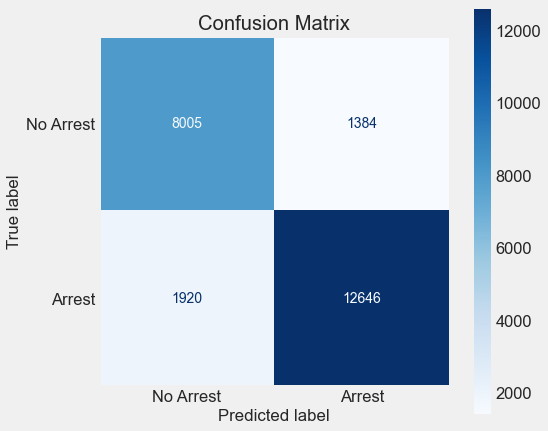

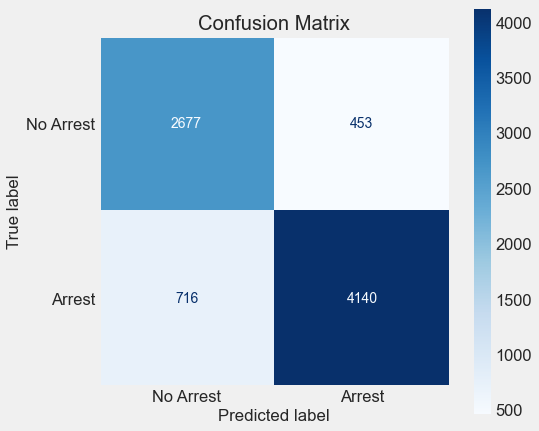

,Train F1,Test F1
0,0.884459,0.876283


In [224]:
f.subsplit_test(X_train, y_train, baseline_smote)

## LR All Features Dropped Subject Age Nulls Score: F1=0.876283

## Grid Searching Parameters

In [225]:
# C = np.logspace(-4, 2, 20)
# penalty = ['l1', 'l2']
# solver = ['liblinear', 'saga', 'lbfgs']


# grid_values = {'logisticregression__C':C, 
#                'logisticregression__penalty':penalty,
#                'logisticregression__solver':solver}

# grid_clf_f1 = GridSearchCV(baseline_nosmote, param_grid = grid_values,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf_f1.fit(X_train, y_train)

In [226]:
# print('Best C:', grid_clf_f1.best_estimator_.get_params()['logisticregression__C'])
# print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['logisticregression__penalty'])
# print('Best solver:', grid_clf_f1.best_estimator_.get_params()['logisticregression__solver'])

## Tuning LR Model

In [227]:
LR_tuned = LogisticRegression(C=1.2742749857031321,
                            solver='lbfgs', penalty='l2',
                            max_iter=1000, class_weight=None,
                              n_jobs=-1)

## Scoring

In [228]:
pipeline  = make_pipeline(preprocessing_mm, LR_tuned)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR Tuned', 'C=1.2742749857031321,\
solver=lbfgs, penalty=l2class_weight=None')

LR Tuned has an average F1 of 0.8878052434391641


array([0.89285714, 0.88838211, 0.88762626, 0.88380282, 0.88635788])

In [229]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
8,LR w/o SMOTE,0.885421,"Top Features w/o Time, Dropped Nulls"
9,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"


## Testing Tuned Model on Sub-Splits

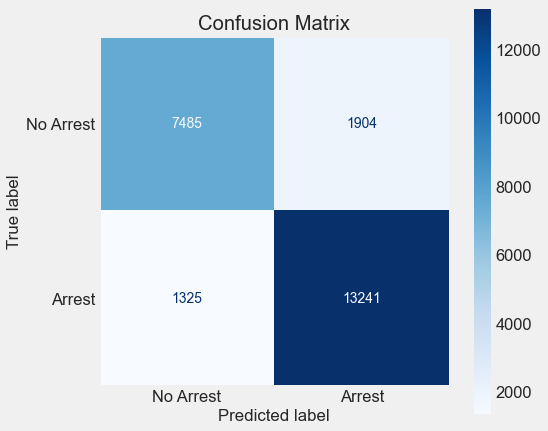

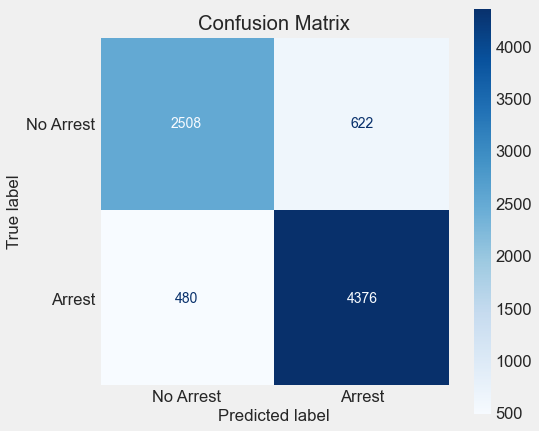

,Train F1,Test F1
0,0.89132,0.888167


In [230]:
f.subsplit_test(X_train, y_train, pipeline)

## Tuned LR Model Score: F1=0.888167 (All Features, Dropped Nulls)

## Random Forest Baseline

## Pipeline

In [231]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

In [232]:
rf_pipeline = make_pipeline(preprocessing_mm, RF)

## Scoring

In [233]:
modeling.report(rf_pipeline, X_train, y_train, 'RF Baseline', 'Random Forest w/o SMOTE')

RF Baseline has an average F1 of 0.8933431327379935


array([0.89841589, 0.89230769, 0.89436796, 0.89089315, 0.89073097])

In [234]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
8,LR w/o SMOTE,0.885421,"Top Features w/o Time, Dropped Nulls"
9,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"


## Subsplits

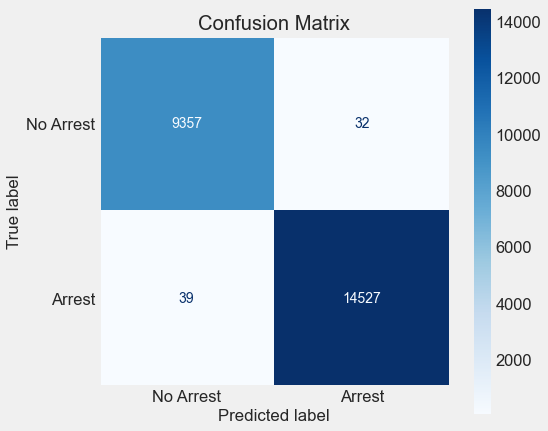

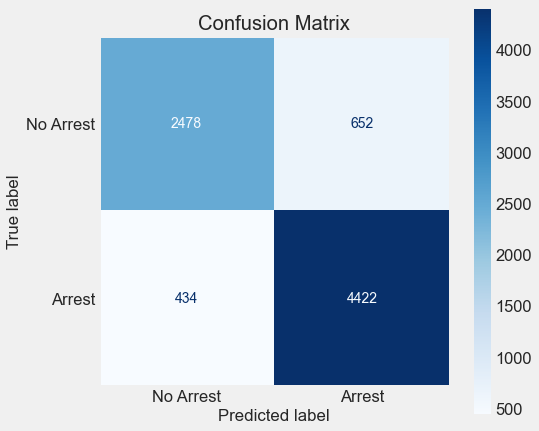

,Train F1,Test F1
0,0.997562,0.890634


In [235]:
f.subsplit_test(X_train, y_train, rf_pipeline)

## RF Baseline Score: F1=0.890634

## Random Forest w/ SMOTE

## Pipeline

In [236]:
rf_sm_pipeline = make_sm_pipeline(preprocessing_mm, sm, RF)

## Scoring

In [237]:
modeling.report(rf_sm_pipeline, X_train, y_train, 'RF SMOTE', 'Random Forest SMOTE')

RF SMOTE has an average F1 of 0.8916655086768314


array([0.89781483, 0.8877331 , 0.89269953, 0.8897281 , 0.89035199])

In [238]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
8,LR w/o SMOTE,0.885421,"Top Features w/o Time, Dropped Nulls"
9,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"


## Subsplits

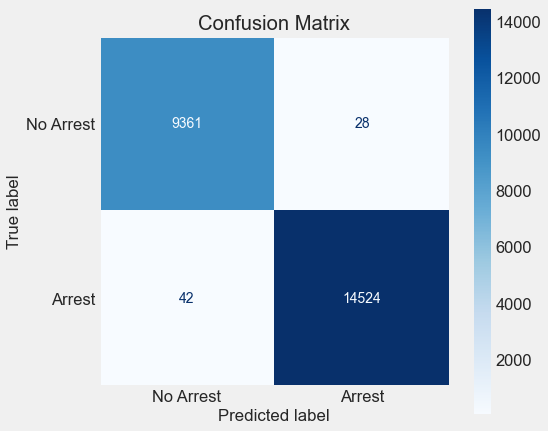

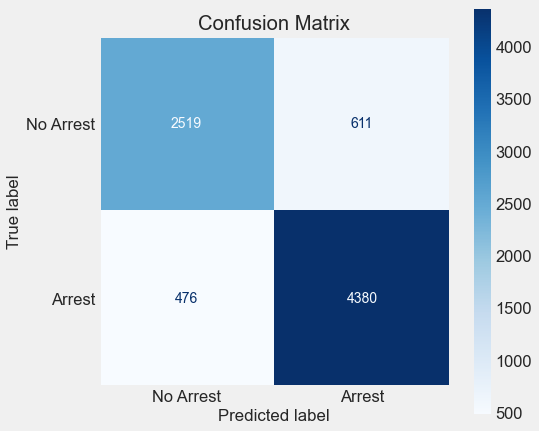

,Train F1,Test F1
0,0.997596,0.889611


In [239]:
f.subsplit_test(X_train, y_train, rf_sm_pipeline)

## RF w/SMOTE Score: F1=0.889611

## Tuning RF Baseline

## GridSearch

In [240]:
# criterion =['gini', 'entropy']
# max_depth = [2, 10, None]
# min_samples_split = [2, 10]
# max_features = [None, 'auto']
# min_samples_leaf = [1, 3]

# grid_values = {
#                'randomforestclassifier__max_depth':max_depth,
#                'randomforestclassifier__criterion':criterion,
#                'randomforestclassifier__min_samples_split':min_samples_split,
#                'randomforestclassifier__max_features': max_features,
#                'randomforestclassifier__min_samples_leaf': min_samples_leaf}

# grid_rf_f1 = GridSearchCV(rf_pipeline, param_grid = grid_values, scoring = 'f1',
#                           n_jobs=-1, verbose=2, cv=3)
# grid_rf_f1.fit(X_train, y_train)

In [241]:
# f.feature_plot(preprocessing_mm, grid_rf_f1, X_train)

In [242]:
# grid_rf_f1.best_estimator_[0].transformers_[0][1].get_feature_names()

In [243]:
# print('Best criterion:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__criterion'])
# print('Best max_depth:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_depth'])
# print('Best min_samples_split:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_split'])
# print('Best min_samples_leaf:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_leaf'])
# print('Best max_features:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_features'])

## Tuned Random Forest

In [244]:
RF2 = RandomForestClassifier(criterion='entropy',
                            max_depth=None, min_samples_split=10,
                            class_weight=None,
                             min_samples_leaf=1, max_features='auto',
                             n_estimators=100,
                            n_jobs=-1, random_state=2021)

In [245]:
rf_pipeline = make_pipeline(preprocessing_mm, RF2)

In [246]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy',
                                        min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

In [247]:
modeling.report(rf_pipeline, X_train, y_train, 'RF Tuned', 'criterion=entropy,\
                            max_depth=None, min_samples_split=10,\
                            class_weight=None,\
                            in_samples_leaf=1, max_features=auto,\
                            n_estimators=100,\
                            n_jobs=-1, random_state=2021')

RF Tuned has an average F1 of 0.896066695136874


array([0.90325   , 0.89435383, 0.89344672, 0.89537773, 0.89390519])

In [248]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
8,LR w/o SMOTE,0.885421,"Top Features w/o Time, Dropped Nulls"
9,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"


## Testing on Subsplits

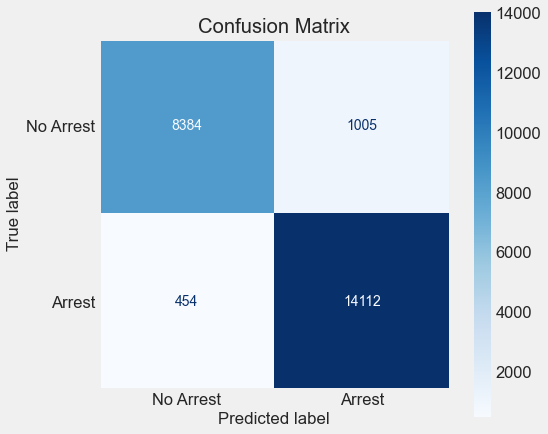

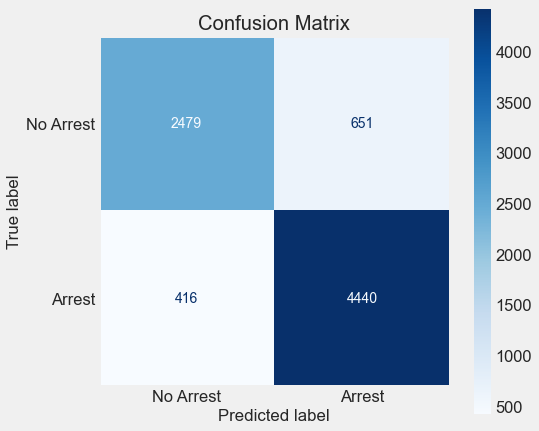

,Train F1,Test F1
0,0.950847,0.892731


In [249]:
f.subsplit_test( X_train, y_train, rf_pipeline)

## RF Tuned Score: F1=0.892731

## Re-Checking the Data

In [250]:
for col in df.columns:
    print(col, df[col].nunique())

Target 2
Subject Age Group 6
Weapon Type 22
Officer ID 1153
Officer Gender 2
Officer Race 7
Subject Perceived Race 9
Subject Perceived Gender 6
Initial Call Type 165
Final Call Type 201
Call Type 6
Officer Squad 163
Frisk Flag 2
Precinct 6
Weapon Flag 2
Reported Year 7
Reported Month 12
Day of Month 31
Day of Week 7
Reported Hour 24
Beat Flag 2
Officer Age 50
Racial Affinity 2
Gender Affinity 2
Weapon Bins 4
Initial Call Bin 2
Call Type Bins 3
Officer Squad Bins 6
Officer Race Bins 2


## More Feature Engineering

## New Data Frame

In [251]:
excluded = ['Officer ID','Final Call Type', 'Weapon Type', 'Officer Gender',
            'Officer Race', 'Frisk Flag', 'Weapon Flag', 'Officer Squad', 
            'Call Type', 'Officer Squad', 'Reported Year', 'Reported Month',
            'Day of Month', 'Day of Week', 'Reported Hour']

In [252]:
df_10 = f.framer(df, [], excluded)

In [253]:
df_10.head(2)

,Target,Subject Age Group,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Precinct,Beat Flag,Officer Age,Racial Affinity,Gender Affinity,Weapon Bins,Initial Call Bin,Call Type Bins,Officer Squad Bins,Officer Race Bins
214,0,1 - 17,White,Male,NA,NA,0,27.0,1,1,NONE,0,OTHER,N,1
328,0,36 - 45,Asian,Male,NA,NA,0,37.0,0,1,NONE,0,OTHER,N,1


In [254]:
X, y = f.Xy(df_10)

In [255]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [256]:
# checking the small df
for col in df_10.columns:
    print(col, df_10[col].nunique())

Target 2
Subject Age Group 6
Subject Perceived Race 9
Subject Perceived Gender 6
Initial Call Type 165
Precinct 6
Beat Flag 2
Officer Age 50
Racial Affinity 2
Gender Affinity 2
Weapon Bins 4
Initial Call Bin 2
Call Type Bins 3
Officer Squad Bins 6
Officer Race Bins 2


## Exploring Initial Call Type

In [257]:
df['Initial Call Re-Bin'] = df['Initial Call Type'].copy()

In [258]:
df['Initial Call Re-Bin'].value_counts(normalize=True)[0:50]

NA                                                  0.283407
SUSPICIOUS STOP - OFFICER INITIATED ONVIEW          0.065815
SUSPICIOUS PERSON, VEHICLE OR INCIDENT              0.063091
DISTURBANCE, MISCELLANEOUS/OTHER                    0.051844
ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS)      0.042781
TRESPASS                                            0.041090
THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS)           0.030313
SHOPLIFT - THEFT                                    0.029256
FIGHT - IP - PHYSICAL (NO WEAPONS)                  0.027049
WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/DIST)      0.024396
ROBBERY - IP/JO (INCLUDES STRONG ARM)               0.019207
BURG - IP/JO - RES (INCL UNOCC STRUCTURES)          0.017047
THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING)       0.015544
DIST - IP/JO - DV DIST - NO ASLT                    0.015098
PROPERTY - DAMAGE                                   0.014675
NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)    0.014276
ASLT - IP/JO - DV       

## Re-Binning Initial Call Type
Grouping similar call types into bins.

In [259]:
categories = df['Initial Call Re-Bin'].unique()

In [260]:
alarms = [x for x in categories if 'ALARM' in x]

In [261]:
assaults = [x for x in categories if 'ASLT -' in x ]

In [262]:
burglaries = [x for x in categories if 'BURG -' in x]

In [263]:
fights = [x for x in categories if 'FIGHT -' in x]

In [264]:
weapons = [x for x in categories if 'WEAPN' in x]

In [265]:
warrants = [x for x in categories if 'WARRANT -' in x]

In [266]:
narcos = [x for x in categories if 'NARCOTICS ' in x]

In [267]:
shots = [x for x in categories if 'SHOTS' in x]

In [268]:
autos = [x for x in categories if 'AUTO ' in x]

In [269]:
for type in alarms:
    df['Initial Call Re-Bin'].replace(type, 'ALARM BIN', inplace=True)
for type in assaults:
    df['Initial Call Re-Bin'].replace(type, 'ASLT BIN', inplace=True)
for type in burglaries:
    df['Initial Call Re-Bin'].replace(type, 'BURG BIN', inplace=True)
for type in fights:
    df['Initial Call Re-Bin'].replace(type, 'FIGHT BIN', inplace=True)
for type in weapons:
    df['Initial Call Re-Bin'].replace(type, 'WEAPN BIN', inplace=True)
for type in warrants:
    df['Initial Call Re-Bin'].replace(type, 'WARRANT BIN', inplace=True)
for type in narcos:
    df['Initial Call Re-Bin'].replace(type, 'NARCOTICS BIN', inplace=True)
for type in shots:
    df['Initial Call Re-Bin'].replace(type, 'SHOTS BIN', inplace=True)
for type in autos:
    df['Initial Call Re-Bin'].replace(type, 'AUTO BIN', inplace=True)

## Checking Value Counts

In [270]:
df['Initial Call Re-Bin'].value_counts(normalize=True)[:50]

NA                                                 0.283407
ASLT BIN                                           0.079410
SUSPICIOUS STOP - OFFICER INITIATED ONVIEW         0.065815
SUSPICIOUS PERSON, VEHICLE OR INCIDENT             0.063091
DISTURBANCE, MISCELLANEOUS/OTHER                   0.051844
TRESPASS                                           0.041090
FIGHT BIN                                          0.040574
BURG BIN                                           0.037498
THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS)          0.030313
SHOPLIFT - THEFT                                   0.029256
WEAPN BIN                                          0.028622
ROBBERY - IP/JO (INCLUDES STRONG ARM)              0.019207
AUTO BIN                                           0.016483
THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING)      0.015544
DIST - IP/JO - DV DIST - NO ASLT                   0.015098
NARCOTICS BIN                                      0.014699
PROPERTY - DAMAGE                       

## Moving Smaller Categories into a Single `Other` Bin

In [271]:
proportions = df['Initial Call Re-Bin'].value_counts(normalize=True)
cutoff_idx = proportions.loc[proportions < .004].index
for i in cutoff_idx:
    df['Initial Call Re-Bin'].replace(i, 'OTHER', inplace=True)

## Checking New Value Counts

In [272]:
df['Initial Call Re-Bin'].value_counts(normalize=True)

NA                                               0.283407
ASLT BIN                                         0.079410
OTHER                                            0.077485
SUSPICIOUS STOP - OFFICER INITIATED ONVIEW       0.065815
SUSPICIOUS PERSON, VEHICLE OR INCIDENT           0.063091
DISTURBANCE, MISCELLANEOUS/OTHER                 0.051844
TRESPASS                                         0.041090
FIGHT BIN                                        0.040574
BURG BIN                                         0.037498
THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS)        0.030313
SHOPLIFT - THEFT                                 0.029256
WEAPN BIN                                        0.028622
ROBBERY - IP/JO (INCLUDES STRONG ARM)            0.019207
AUTO BIN                                         0.016483
THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING)    0.015544
DIST - IP/JO - DV DIST - NO ASLT                 0.015098
NARCOTICS BIN                                    0.014699
PROPERTY - DAM

## Binning Subject Race
Binning into White, Black, and Other.

In [273]:
df['Subject Perceived Race'].unique()

array(['White', 'Asian', 'Unknown', 'Black', 'N_American', 'Multi-Racial',
       'Hispanic', 'Other', 'P_Islander'], dtype=object)

In [274]:
df['Subject Perceived Race'].value_counts(normalize=True)

White           0.516237
Black           0.309610
Unknown         0.052290
Hispanic        0.037592
Asian           0.033952
N_American      0.030149
Multi-Racial    0.015614
Other           0.003311
P_Islander      0.001244
Name: Subject Perceived Race, dtype: float64

In [275]:
df['Subject Perceived Race'].replace('White', 0, inplace=True)
df['Subject Perceived Race'].replace('Black', 1, inplace=True)

In [276]:
types = df['Subject Perceived Race'].unique()
replace_list = [x for x in types if (x!=0) and (x!=1)]
df['Subject Perceived Race'].replace(replace_list, 2, inplace=True)

In [277]:
df['Subject Perceived Race'].value_counts(normalize=True)

0    0.516237
1    0.309610
2    0.174153
Name: Subject Perceived Race, dtype: float64

## Binning Subject Gender
Binning into Male, Female, Other.

In [278]:
df['Subject Perceived Gender'].unique()

array(['Male', 'Female', 'Undetermined', 'NA', 'Unknown',
       'Gender Diverse'], dtype=object)

In [279]:
df['Subject Perceived Gender'].value_counts(normalize=True)

Male              0.793820
Female            0.203503
Undetermined      0.002043
Unknown           0.000258
NA                0.000258
Gender Diverse    0.000117
Name: Subject Perceived Gender, dtype: float64

In [280]:
df['Subject Perceived Gender'].replace('Male', 0, inplace=True)
df['Subject Perceived Gender'].replace('Female', 1, inplace=True)

In [281]:
types = df['Subject Perceived Gender'].unique()
replace_list = [x for x in types if (x!=0) and (x!=1)]
df['Subject Perceived Gender'].replace(replace_list, 2, inplace=True)

In [282]:
df['Subject Perceived Gender'].value_counts(normalize=True)

0    0.793820
1    0.203503
2    0.002677
Name: Subject Perceived Gender, dtype: float64

## DF With Re-engineered Data

In [283]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag',
           'Reported Year', 'Reported Month', 'Day of Month', 'Day of Week', 'Reported Hour']

In [284]:
df_11 = f.framer(df, [], excluded)

In [285]:
df_11.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,...,Beat Flag,Officer Age,Racial Affinity,Gender Affinity,Weapon Bins,Initial Call Bin,Call Type Bins,Officer Squad Bins,Officer Race Bins,Initial Call Re-Bin
214,0,1 - 17,None,Male,White,0,0,NA,NA,NA,...,0,27.0,1,1,NONE,0,OTHER,N,1,NA
328,0,36 - 45,None,Male,White,2,0,NA,NA,NA,...,0,37.0,0,1,NONE,0,OTHER,N,1,NA


In [286]:
X, y = f.Xy(df_11)

In [287]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Tuned RF on New Data

In [288]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy',
                                        min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

## Scoring

In [289]:
modeling.report(rf_pipeline, X_train, y_train, 'RF Tuned New Data', 'criterion=entropy,\
                            max_depth=None, min_samples_split=10,\
                            class_weight=None,\
                            in_samples_leaf=1, max_features=auto,\
                            n_estimators=100,\
                            n_jobs=-1, random_state=2021')

RF Tuned New Data has an average F1 of 0.8963121497488211


array([0.90147537, 0.89442705, 0.89555972, 0.89562624, 0.89447236])

In [290]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
8,LR w/o SMOTE,0.885421,"Top Features w/o Time, Dropped Nulls"
9,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"


## Testing on Subsplits

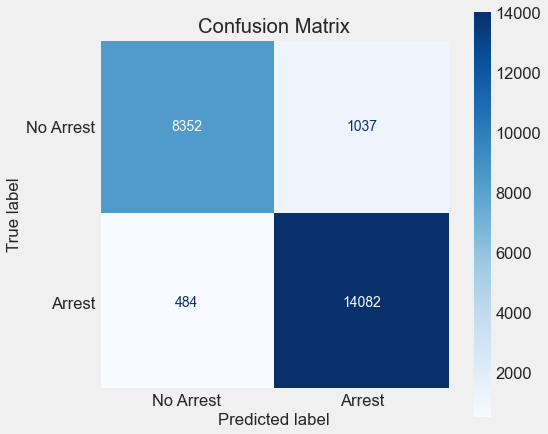

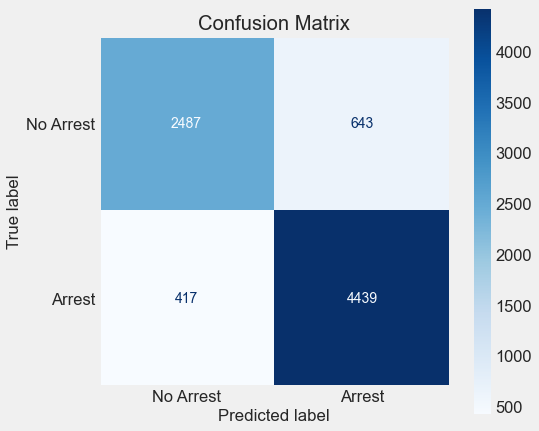

,Train F1,Test F1
0,0.948762,0.893339


In [291]:
f.subsplit_test( X_train, y_train, rf_pipeline)

## Tuned RF on New Data Score: F1=0.893339

## Re-Tuning Models on New Data

## LR All Data

In [292]:
LR_ALL = LogisticRegression(random_state=2021, n_jobs=-1)

In [293]:
pipeline = make_pipeline(preprocessing_mm, LR_ALL)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1, random_state=2021))])

In [294]:
f1_score(y_train, pipeline.predict(X_train))

0.8903251868309432

## GridSearch

In [295]:
C = np.logspace(-4, 2, 20)
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga', 'lbfgs']


grid_values = {'logisticregression__C':C, 
               'logisticregression__penalty':penalty,
               'logisticregression__solver':solver}

grid_clf_f1_all = GridSearchCV(pipeline, param_grid = grid_values,
                           n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
grid_clf_f1_all.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


/Users/dsbox/opt/anaconda3/envs/terry_stops/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.         0.75626424        nan 0.86972478 0.86985629 0.86985629
 0.         0.75626424        nan 0.86968483 0.86953427 0.869561
 0.86985629 0.83067763        nan 0.87044788 0.87044788 0.87044788
 0.86985629 0.86985629        nan 0.87101589 0.87127075 0.87127907
 0.86900774 0.86900774        nan 0.87965133 0.87974857 0.87963938
 0.86900774 0.86900774        nan 0.88271755 0.88298721 0.88296986
 0.88145639 0.88145639        nan 0.88470202 0.88469999 0.88474309
 0.88156585 0.88156585        nan 0.88531226 0.88526152 0.88532778
 0.88351613 0.8835437         nan 0.88582992 0.88576865 0.8857964
 0.88467389 0.88465792        nan 0.88687206 0.88684988 0.88683822
 0.88591384 0.88591384        nan 0.88758889 0.88761115 0.88756062
 0.88676285 0.88670664        nan 0.88752626 0.88752626 0.88754853
 0.8870963  0.88707968     

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                                        ('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)]))...
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.35981829e-02, 6.95192796e-02, 1.43844989e-01, 2.97635144e-01,
       6.15848211e-01, 1.27427499e+00, 2.63665090e+00, 5.45559478e+00,
   

In [296]:
print('Best C:', grid_clf_f1_all.best_estimator_.get_params()['logisticregression__C'])
print('Best penalty:', grid_clf_f1_all.best_estimator_.get_params()['logisticregression__penalty'])
print('Best solver:', grid_clf_f1_all.best_estimator_.get_params()['logisticregression__solver'])

Best C: 2.6366508987303554
Best penalty: l2
Best solver: lbfgs


In [297]:
LR_ALL_tuned = LogisticRegression(C=2.6366508987303554,
                            solver='lbfgs', penalty='l2',
                              class_weight=None,
                            max_iter=1000, n_jobs=-1)

pipeline  = make_pipeline(preprocessing_mm, LR_ALL_tuned)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR_ALL Tuned',\
                'C=2.6366508987303554, penalty=l2,\
                solver=lbfgs, class_weight=None')

LR_ALL Tuned has an average F1 of 0.8872832847319995


array([0.8926639 , 0.88779129, 0.88737374, 0.88332914, 0.88525836])

In [298]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
8,LR w/o SMOTE,0.885421,"Top Features w/o Time, Dropped Nulls"
9,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"


## LR Coefficients & Odds

In [299]:
features = list(grid_clf_f1_all.best_estimator_[0].\
                transformers_[0][1].\
                get_feature_names())+\
                list(X_train.select_dtypes('number').columns)

In [300]:
coeff = grid_clf_f1_all.best_estimator_[1].coef_.flatten()

In [301]:
coefficients = pd.DataFrame(coeff, features, columns=['coef'])\
                            .sort_values(by='coef', ascending=False)

In [302]:
top20_pos_coef = coefficients.head(20)

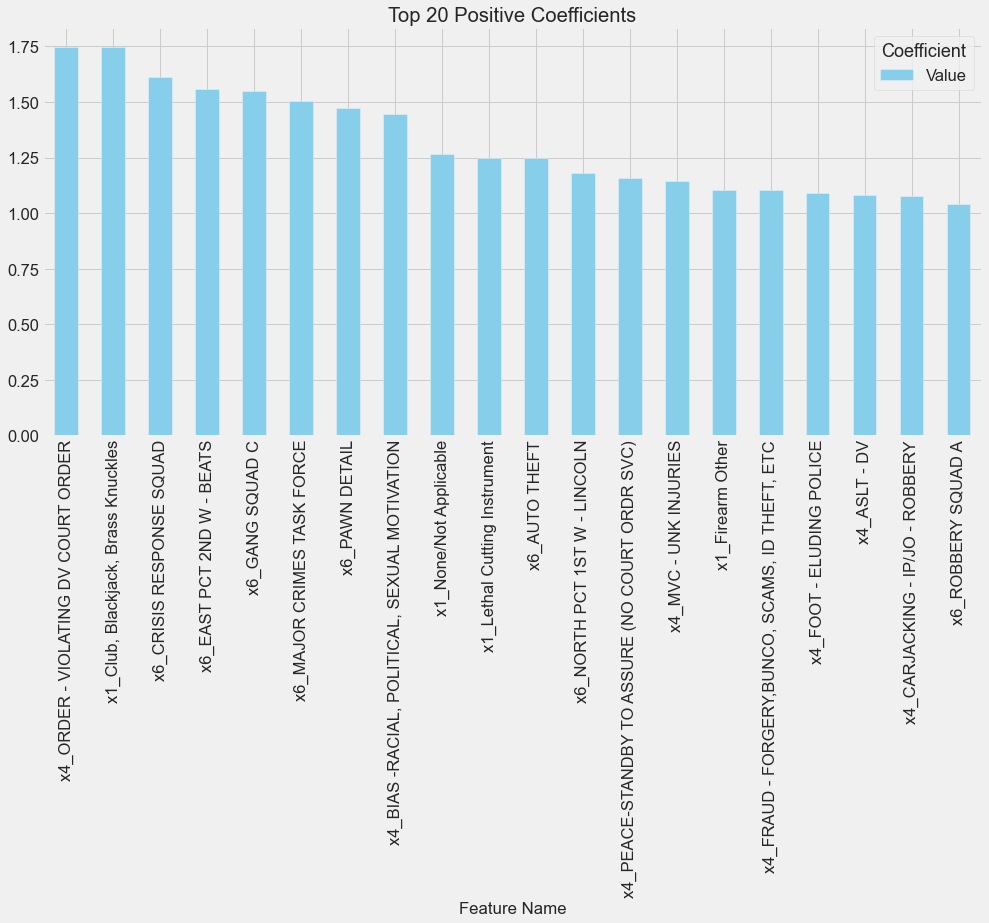

In [303]:
top20_pos_coef.plot(kind='bar', figsize=(15,7), color=['skyblue'])
plt.title('Top 20 Positive Coefficients')                                                 
plt.xlabel('Feature Name')
plt.xticks(rotation=90)
plt.legend(title='Coefficient', labels=['Value'])
plt.show()

In [304]:
top20_neg_coef = coefficients.tail(20)

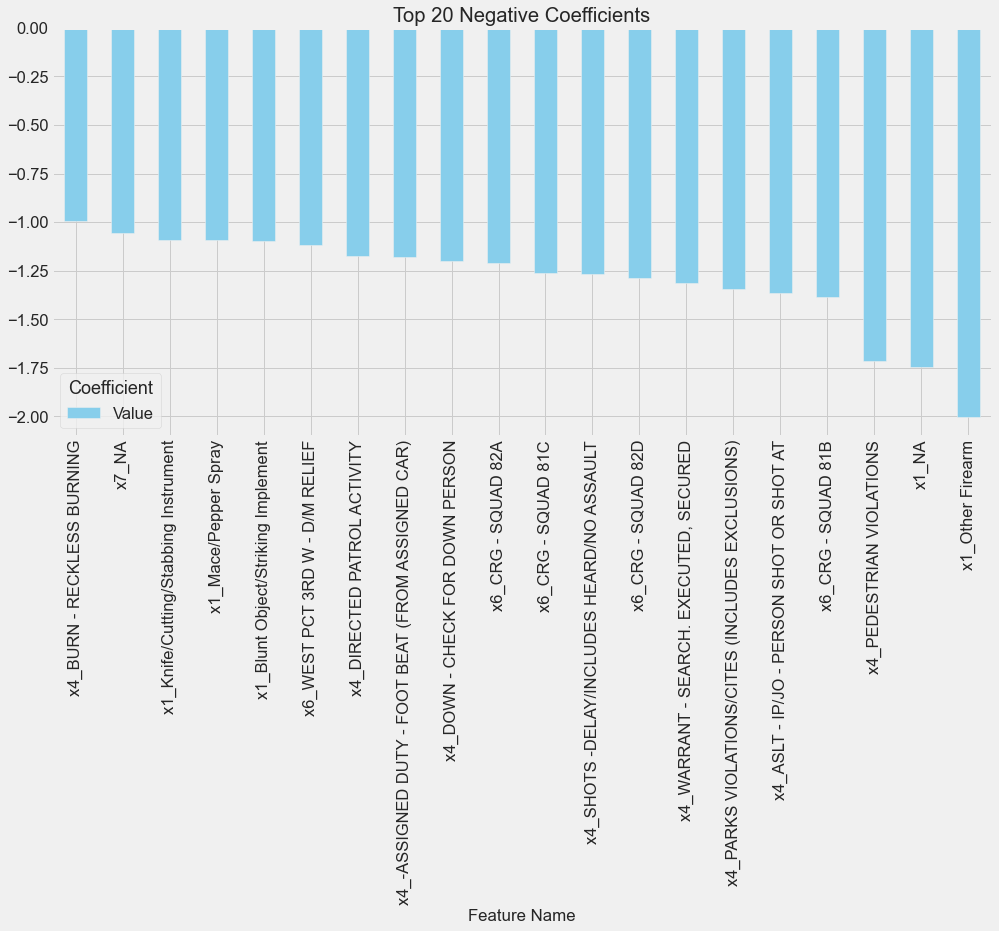

In [305]:
top20_neg_coef.plot(kind='bar', figsize=(15,7), color=['skyblue'])
plt.title('Top 20 Negative Coefficients')                                                 
plt.xlabel('Feature Name')
plt.xticks(rotation=90)
plt.legend(title='Coefficient', labels=['Value'])
plt.show()

In [306]:
odds = np.exp(coeff)
odds_df = pd.DataFrame(odds, 
             features, 
             columns=['odds'])\
            .sort_values(by='odds', ascending=False)

In [307]:
top20_pos_odds = odds_df.head(20).reset_index()

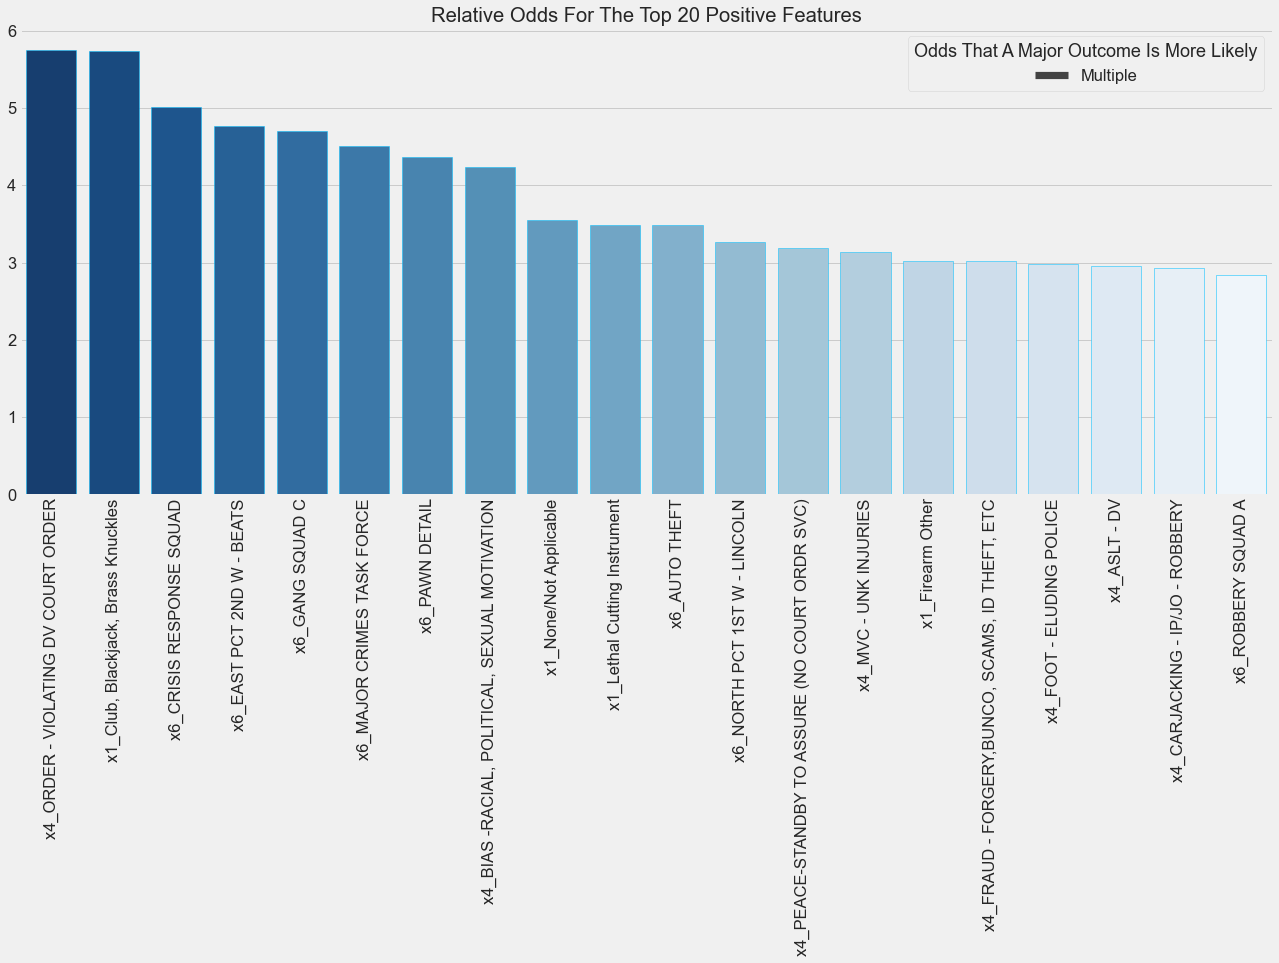

In [378]:
fig, ax = plt.subplots(figsize =(20, 8))
sns.barplot(x='index',y='odds', data=top20_pos_odds, palette='Blues_r', edgecolor='deepskyblue')
plt.title('Relative Odds For The Top 20 Positive Features')                                                 
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.legend(title='Odds That A Major Outcome Is More Likely', labels=['Multiple'])
# plt.savefig('LR_Positive',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

In [309]:
top20_neg_odds = odds_df.tail(20).reset_index()

In [311]:
top20_neg_odds['odds'] = 1/top20_neg_odds['odds']

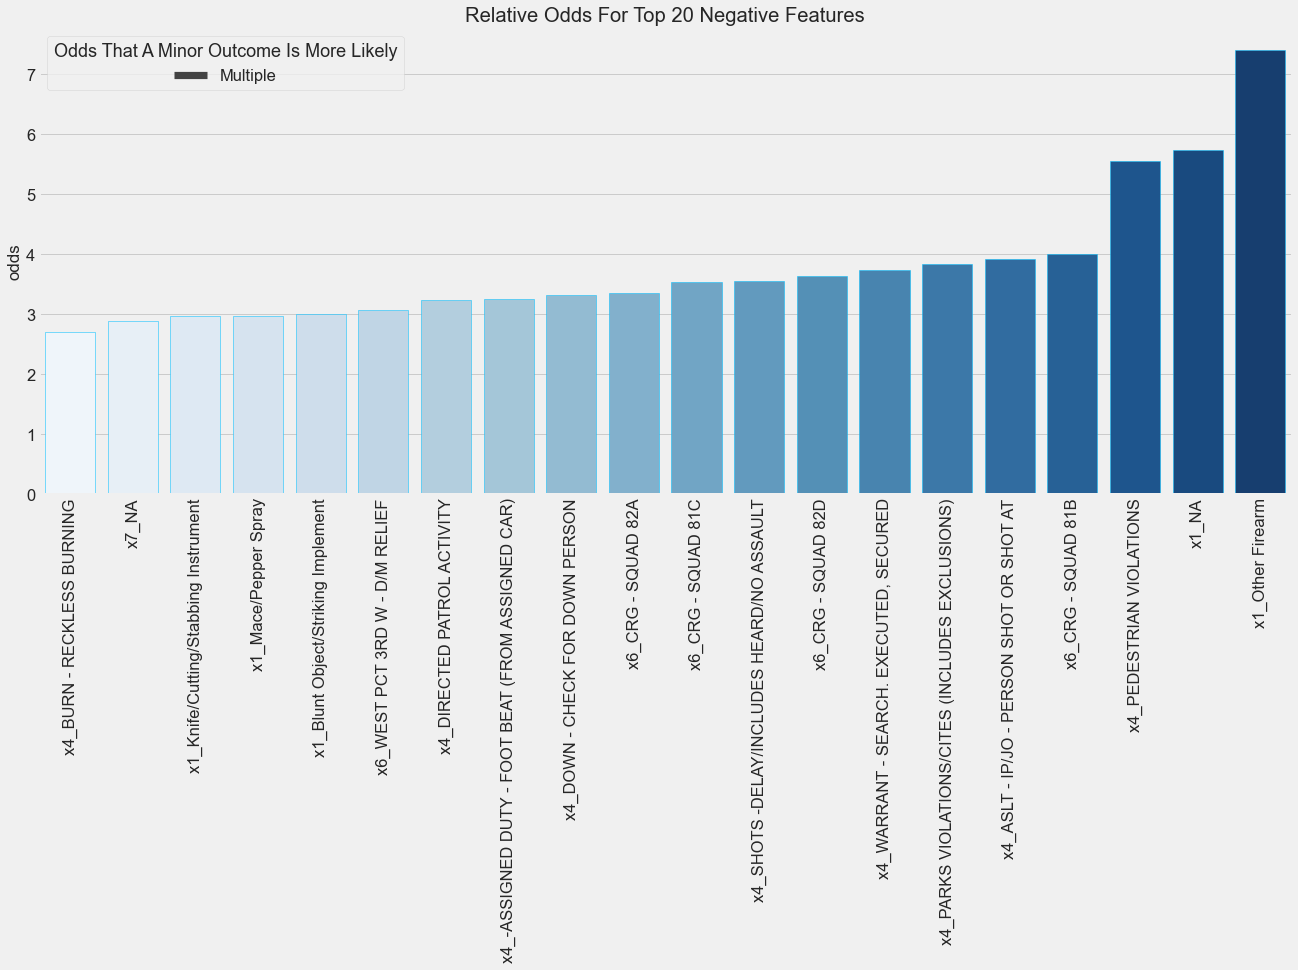

In [379]:
fig, ax = plt.subplots(figsize =(20, 8))
sns.barplot(x='index',y='odds', data=top20_neg_odds, palette='Blues', edgecolor='deepskyblue')
plt.title('Relative Odds For Top 20 Negative Features')                                                 
plt.xlabel('')
plt.xticks(rotation=90)
plt.legend(title='Odds That A Minor Outcome Is More Likely', labels=['Multiple'])
# plt.savefig('LR_Negative',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

## Testing Tuned Model on Sub-Splits

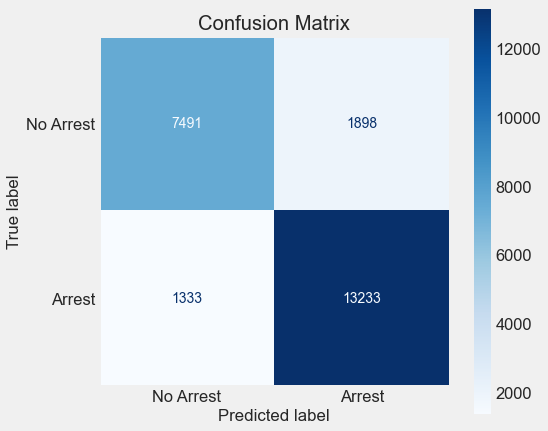

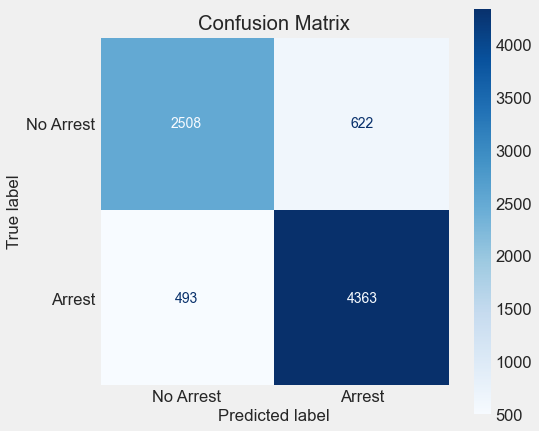

,Train F1,Test F1
0,0.891201,0.886699


In [314]:
f.subsplit_test(X_train, y_train, pipeline)

## Tuned LR on All Data Score: F1=0.886699

## RF Tuned on All Data

In [315]:
RF5 = RandomForestClassifier(n_jobs=-1,
                            random_state=2021)

In [316]:
rf2_pipeline = make_pipeline(preprocessing_mm, RF5)
rf2_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

## Gridsearch

In [317]:
# criterion =['gini', 'entropy']
# max_depth = [2, 10, None]
# min_samples_split = [2, 10]
# max_features = [None, 'auto']
# min_samples_leaf = [1, 3]

# grid_values = {
#                'randomforestclassifier__max_depth':max_depth,
#                'randomforestclassifier__criterion':criterion,
#                'randomforestclassifier__min_samples_split':min_samples_split,
#                'randomforestclassifier__max_features': max_features,
#                'randomforestclassifier__min_samples_leaf': min_samples_leaf}

# grid_rf2_f1 = GridSearchCV(rf2_pipeline, param_grid = grid_values, scoring = 'f1',
#                           n_jobs=-1, verbose=2, cv=3)
# grid_rf2_f1.fit(X_train, y_train)

In [318]:
# print('Best criterion:', grid_rf2_f1.best_estimator_.get_params()['randomforestclassifier__criterion'])
# print('Best max_depth:', grid_rf2_f1.best_estimator_.get_params()['randomforestclassifier__max_depth'])
# print('Best min_samples_split:', grid_rf2_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_split'])
# print('Best min_samples_leaf:', grid_rf2_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_leaf'])
# print('Best max_features:', grid_rf2_f1.best_estimator_.get_params()['randomforestclassifier__max_features'])

## Tuning

In [319]:
RF_ALL = RandomForestClassifier(criterion='gini',
                             max_depth=None,
                             min_samples_split=10,
                                max_features='auto',
                                min_samples_leaf=1,
                                n_jobs=-1,
                                n_estimators=100,
                            random_state=2021)

In [320]:
rfall_pipeline = make_pipeline(preprocessing_mm, RF_ALL)
rfall_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

## Scoring

In [321]:
modeling.report(rfall_pipeline, X_train, y_train, 'RF_ALL Tuned', 'criterion=gini,\
                                                            max_depth=None,\
                                                            min_samples_split=10,\
                                                            class_weight=None,\
                                                            min_samples_leaf=1,\
                                                            max_features=auto,\
                                                            n_estimators=100')

RF_ALL Tuned has an average F1 of 0.8968056186879323


array([0.90352412, 0.89542157, 0.89651729, 0.89455359, 0.89401153])

In [322]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
8,LR w/o SMOTE,0.885421,"Top Features w/o Time, Dropped Nulls"
9,LR w/o SMOTE,0.885498,"Dropped Nulls, call type bins"


## Feature Importance

In [324]:
# f.feature_plot(preprocessing_mm, grid_rf2_f1, X_train)

In [325]:
# grid_rf2_f1.best_estimator_[0].transformers_[0][1].get_feature_names()

## Testing on Subsplits

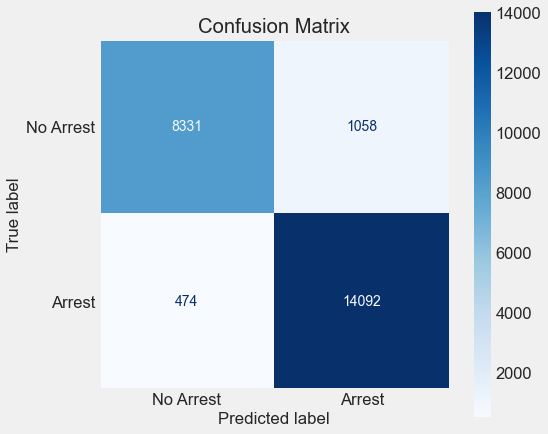

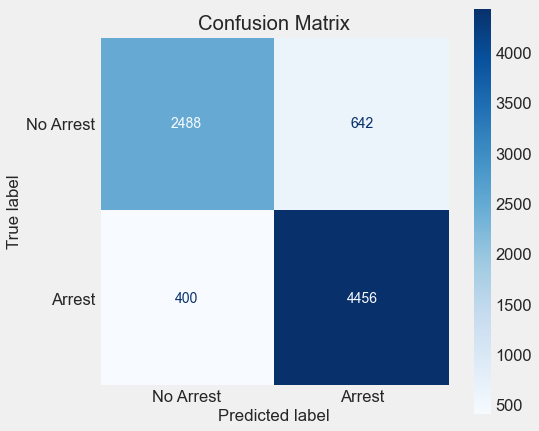

,Train F1,Test F1
0,0.948445,0.895318


In [326]:
f.subsplit_test( X_train, y_train, rfall_pipeline)

## Tuned RF on All Data Score: F1=0.895318

## AdaBoost

## Pipeline

In [327]:
ada = AdaBoostClassifier(random_state=2021)

ada_pipeline = make_pipeline(preprocessing_mm, ada)

In [328]:
ada_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('adaboostclassifier', AdaBoostClassifier(random_state=2021))])

## Scoring

In [329]:
#scoring the model
f1_score(y_train, ada_pipeline.predict(X_train))

0.8861885592167388

In [330]:
# checking cross val scores
modeling.report(ada_pipeline, X_train, y_train,\
                'AdaBoost Baseline', 'All Data')

AdaBoost Baseline has an average F1 of 0.8851487145451644


array([0.88762517, 0.88528274, 0.88772716, 0.88046431, 0.88464419])

In [331]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"
24,AdaBoost Baseline,0.885149,All Data
8,LR w/o SMOTE,0.885421,"Top Features w/o Time, Dropped Nulls"


## Subsplits

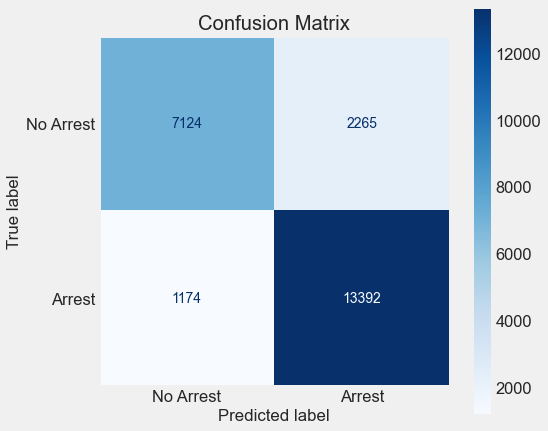

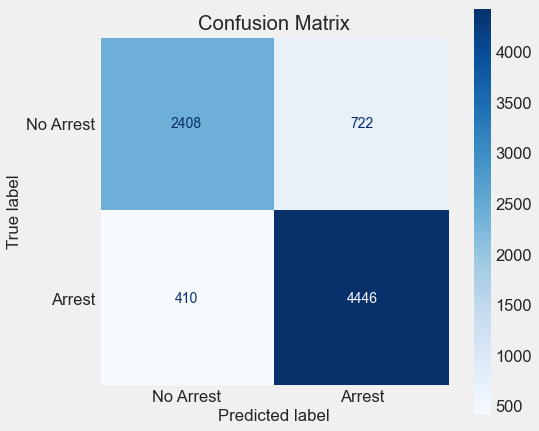

,Train F1,Test F1
0,0.886212,0.887071


In [332]:
f.subsplit_test(X_train, y_train, ada_pipeline)

## AdaBoost Baseline Score: F1=0.887071

## AdaBoost with LR

## Pipeline

In [339]:
ada = AdaBoostClassifier(base_estimator=LR_ALL, random_state=2021)

adaLR_pipeline = make_pipeline(preprocessing_mm, ada)

In [340]:
adaLR_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=LogisticRegression(n_jobs=-1,
                                                                      random_state=2021),
                                    random_state=2021))])

## Scoring

In [341]:
#scoring the model
f1_score(y_train, adaLR_pipeline.predict(X_train))

0.8837347165616896

In [342]:
# checking cross val scores
modeling.report(adaLR_pipeline, X_train, y_train,\
                'AdaBoostLR', 'All Data')

AdaBoostLR has an average F1 of 0.8836109302377111


array([0.88708087, 0.88191516, 0.88647313, 0.88013783, 0.88244767])

In [343]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
26,AdaBoostLR,0.883611,All Data
7,AdaBoostLR,0.883611,All Data
8,LR w/o SMOTE,0.884717,"Dropped Nulls, Squad Bins"


## Subsplits

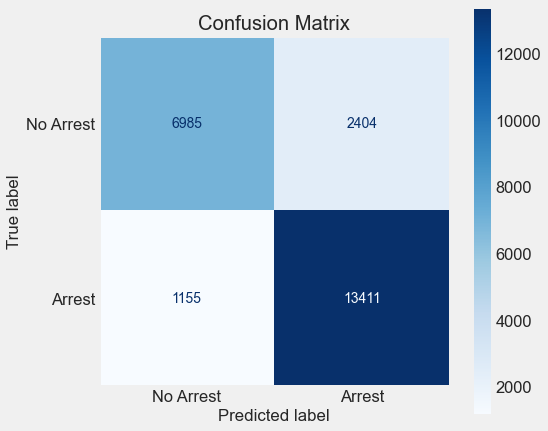

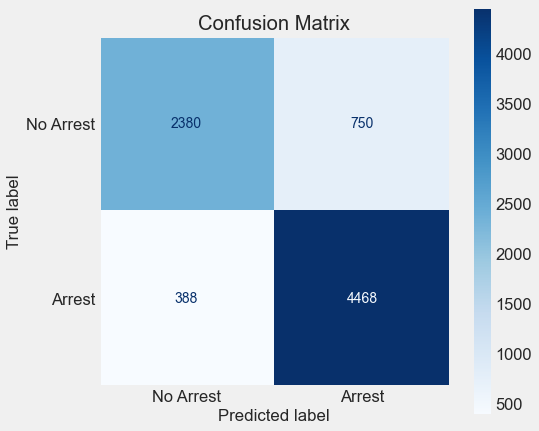

,Train F1,Test F1
0,0.882854,0.887036


In [344]:
f.subsplit_test(X_train, y_train, adaLR_pipeline)

## AdaBoost w/LR Score: F1=0.887036

## AdaBoost LR Tuned

In [345]:
# adaLR_pipeline.get_params().keys()

## GridSearch

In [347]:
# parameters = {
#               'adaboostclassifier__n_estimators':[10,50,100,250],
#               'adaboostclassifier__learning_rate':[.01,.1,.5, 1]}

# adaGCV = GridSearchCV(adaLR_pipeline, parameters,verbose=2,
#                    scoring='f1',n_jobs=-1, cv=3)
# adaGCV.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                                        ('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                                       ('adaboostclassifier',
                                        AdaBoostClassifier(base_estimator=LogisticRegression(n_jobs=-1,
                                                    

In [348]:
# print('Best learning_rate:', adaGCV.best_estimator_.get_params()['adaboostclassifier__learning_rate'])
# print('Best n_estimators:', adaGCV.best_estimator_.get_params()['adaboostclassifier__n_estimators'])

Best learning_rate: 1
Best n_estimators: 250


## Tuning

In [349]:
ada = AdaBoostClassifier(base_estimator=LR_ALL, learning_rate=1,
                         n_estimators=250, random_state=2021)

adaLR_ALL = make_pipeline(preprocessing_mm, ada)

In [351]:
adaLR_ALL.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=LogisticRegression(n_jobs=-1,
                                                                      random_state=2021),
                                    learning_rate=1, n_estimators=250,
                                    random_state=2021))])

## Scoring

In [352]:
# #scoring the model
f1_score(y_train, adaLR_ALL.predict(X_train))

0.8851154811923526

In [353]:
# checking cross val scores
modeling.report(adaLR_ALL, X_train, y_train,\
                'AdaBoostLR_ALL', 'All Data')

AdaBoostLR_ALL has an average F1 of 0.8846512495593034


array([0.88806248, 0.88303583, 0.88888889, 0.88016836, 0.8831007 ])

In [354]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,AdaBoostLR,0.883611,All Data
8,AdaBoostLR,0.883611,All Data
27,AdaBoostLR_ALL,0.884651,All Data


## Subsplits

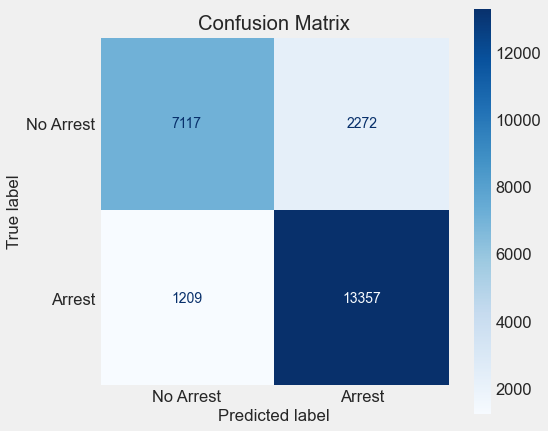

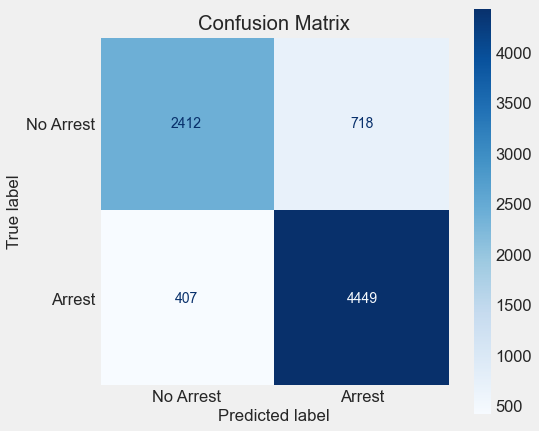

,Train F1,Test F1
0,0.884716,0.887758


In [356]:
f.subsplit_test(X_train, y_train, adaLR_ALL)

## AdaBoost LR Tuned Score: F1=0.887758

## Plotting a DT

In [357]:
X, y = f.Xy(df_11)

In [380]:
X.head(2)

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Beat Flag,Officer Age,Racial Affinity,Gender Affinity,Weapon Bins,Initial Call Bin,Call Type Bins,Officer Squad Bins,Officer Race Bins,Initial Call Re-Bin
214,1 - 17,None,Male,White,0,0,NA,NA,NA,NA,0,27.0,1,1,NONE,0,OTHER,N,1,NA
328,36 - 45,None,Male,White,2,0,NA,NA,NA,NA,0,37.0,0,1,NONE,0,OTHER,N,1,NA


In [359]:
X_train, X_test, y_train, y_test = f.splitter(X, y)

In [360]:
DT = DecisionTreeClassifier(max_depth=5, random_state=2021)

## Pipeline

In [361]:
pipeline = make_pipeline(preprocessing_mm, DT)

In [362]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=2021))])

## Scoring

In [363]:
f1_score(y_train, pipeline.predict(X_train))

0.8891210786874643

In [364]:
modeling.report(pipeline, X_train, y_train, 'Baseline DT', 'All Data')

Baseline DT has an average F1 of 0.8880999076604306


array([0.89250248, 0.88542576, 0.88781095, 0.88869715, 0.8860632 ])

In [365]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,AdaBoostLR,0.883611,All Data
8,AdaBoostLR,0.883611,All Data
9,AdaBoostLR_ALL,0.884651,All Data


## Subsplits

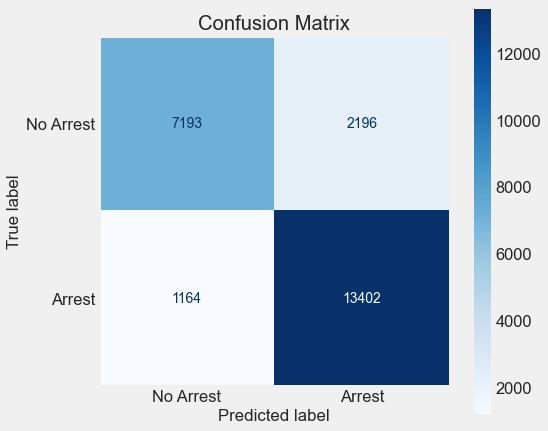

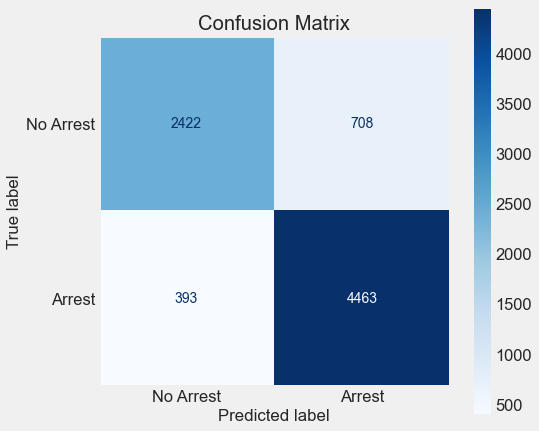

,Train F1,Test F1
0,0.888609,0.890196


In [366]:
f.subsplit_test(X_train, y_train,pipeline)

## DT Baseline Score: F1=0.890196

In [367]:
# plt.figure(figsize=(20,20))
# plot_tree(pipeline[1])
# plt.show()

## XGBoost

## PipeLine

In [368]:
xboostclf = xgb.XGBClassifier(use_label_encoder=False)

In [369]:
X, y = f.Xy(df_11)

In [370]:
X_train, X_test, y_train, y_test = f.splitter(X, y)

In [371]:
xpipeline = make_pipeline(preprocessing_mm, xboostclf)

In [372]:
xpipeline.fit(X_train, y_train)

[20:34:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('xgbclassifier',
                 XGBClassif...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

In [373]:
xpipeline.fit(X_train, y_train)

[20:34:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c38b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ff6c3910>)])),
                ('xgbclassifier',
                 XGBClassif...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

## Scoring

In [374]:
f1_score(y_train, xpipeline.predict(X_train))

0.9151865794194185

In [375]:
modeling.report(xpipeline, X_train, y_train, 'XGBoost Baseline', 'All Data' )

[20:34:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:34:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:34:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

array([0.89827304, 0.88953784, 0.8939126 , 0.8902577 , 0.89181991])

In [376]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR w/o SMOTE,0.873259,"Dropped Nulls, weapon flag"
1,LR w/o SMOTE,0.873273,"Dropped Nulls, weapon bins"
2,LR Baseline SMOTE,0.874411,Log Reg min/max
3,LR SMOTE,0.878441,"LR, Dropped Nulls"
4,LR w/o SMOTE,0.878747,"Dropped Nulls, officer age"
5,LR w/o SMOTE,0.880584,"Dropped Nulls, Initial Call Binary"
6,LR Baseline,0.881053,"Log Reg, min/max"
7,AdaBoostLR,0.883611,All Data
8,AdaBoostLR,0.883611,All Data
9,AdaBoostLR_ALL,0.884651,All Data


## Subsplits

[20:34:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


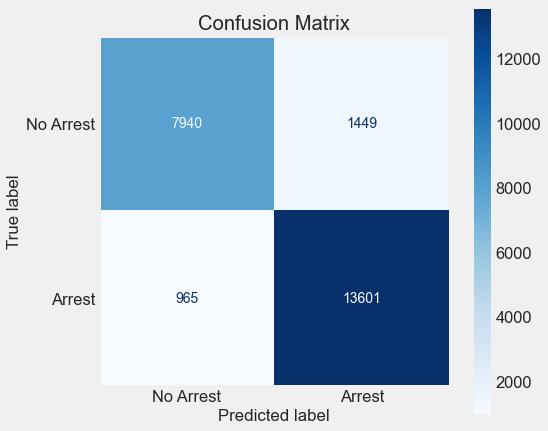

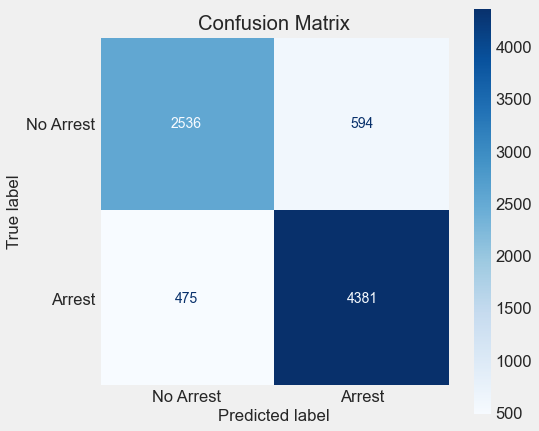

,Train F1,Test F1
0,0.91849,0.891262


In [377]:
f.subsplit_test(X_train, y_train,xpipeline)

## XGBoost Baseline Score: F1=0.891262